In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
import warnings
import pickle
%matplotlib inline

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import adfuller

In [2]:
warnings.simplefilter('ignore')

### Load

In [3]:
train = pd.read_csv('../data/train.csv')

In [4]:
train

ecg
0    -208.878
1    -204.596
2    -193.797
3    -178.728
4    -161.621
...       ...
5995  -49.048
5996  -48.061
5997  -47.127
5998  -46.250
5999  -45.436

[6000 rows x 1 columns]

In [5]:
test_01 = pd.read_csv('../data/test_01.csv')

In [6]:
test_02 = pd.read_csv('../data/test_02.csv')

In [7]:
sc = StandardScaler()

In [8]:
train['ecg'] = sc.fit_transform(train[['ecg']])
test_01['ecg'] = sc.transform(test_01[['ecg']])
test_02['ecg'] = sc.transform(test_02[['ecg']])

In [9]:
train

ecg
0    -1.310333
1    -1.283674
2    -1.216440
3    -1.122623
4    -1.016117
...        ...
5995 -0.315252
5996 -0.309107
5997 -0.303293
5998 -0.297832
5999 -0.292765

[6000 rows x 1 columns]

In [10]:
test_01

ecg
0    -1.562119
1    -1.589563
2    -1.622697
3    -1.659149
4    -1.696187
...        ...
5995 -0.521808
5996 -0.531209
5997 -0.543331
5998 -0.559786
5999 -0.582523

[6000 rows x 1 columns]

In [11]:
test_02

ecg
0    -0.237585
1    -0.240274
2    -0.245143
3    -0.252321
4    -0.261928
...        ...
5995 -0.120190
5996 -0.104675
5997 -0.089758
5998 -0.075494
5999 -0.061835

[6000 rows x 1 columns]

### Model Comparison Direction
- The models will be created here calculate anomaly score on each data point in the time series. 
- There is not enough abnormal pattern data.
- Therefore, model comparison will be conducted manually if a model can detect anomaly which were defined in EDA.ipynb.
- If the data point is irregular, the anomaly socre goes up. I checked the defined area manually if the anomaly score time series have a clear peak compared to other time intervals for the model comparison.

### Function to display data and anomaly score

In [133]:
# grid
sns.set_style('whitegrid')

def display_anomaly_score(test_data_1, test_data_2, anomaly_score_arr_1, anomaly_score_arr_2):
    
    # loop the size of anomaly_scores list
    # both size is same
    for i in range(len(anomaly_score_arr_1)):
        fig, ax = plt.subplots(2, 2, figsize=(12, 8));
        ax = ax.ravel()
        
        for j in range(len(ax)):
            # plot test_data_1 and test_data_2
            if j == 0 or j == 1:
                if j == 0:
                    ax[j].plot(test_data_1);
                    ax[j].set_title('Test Data 01', fontsize=13)
                    
                    # Plot irregular area
                    ax[j].axvspan(1500, 2000, color="red", alpha=0.3, label='Irregular');
                    ax[j].axvspan(4600, 5000, color="red", alpha=0.3);
                    ax[j].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1);
                    
                elif j == 1:
                    ax[j].plot(test_data_2);
                    ax[j].set_title('Test Data 02', fontsize=13)
                    
                    # Plot irregular area
                    ax[j].axvspan(2090, 2450, color="red", alpha=0.3, label='Irregular');
                    ax[j].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1);
                
                ax[j].set_ylim(-7, 7)
                ax[j].set_xlim(0, 6000)
                ax[j].set_ylabel('Normalized ECG', fontsize=13)
                
                    
            else:
                if j == 2:
                    ax[j].plot(anomaly_score_arr_1[i]['anomaly']);
                    ax[j].set_title('Test 01 Anomaly Scores', fontsize=13)
                    
                    # Plot irregular area
                    ax[j].axvspan(1500, 2000, color="red", alpha=0.3, label='Irregular');
                    ax[j].axvspan(4600, 5000, color="red", alpha=0.3);
                    ax[j].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1);
                    
                elif j == 3:
                    ax[j].plot(anomaly_score_arr_2[i]['anomaly']);
                    ax[j].set_title('Test 02 Anomaly Scores', fontsize=13)
                    
                    # Plot irregular area
                    ax[j].axvspan(2090, 2450, color="red", alpha=0.3, label='Irregular');
                    ax[j].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1);
            
                ax[j].set_ylim(0, 1)
                ax[j].set_xlim(0, 6000)
                ax[j].set_ylabel('Anomaly (max = 1)', fontsize=13)
            
            # shared setting
            ax[j].tick_params(axis='x', labelsize=13)
            ax[j].tick_params(axis='y', labelsize=13)
                
            
        # layout and title
        plt.tight_layout()
        fig.suptitle(anomaly_score_arr_1[i]['param_details'], fontsize=20)
        plt.subplots_adjust(top=0.9)
                
        

### Modeling and Calculate Anomaly
### KNearest Neighbors

In [15]:
# a function to create vectors with a window size using sliding window
def embed(data, window_size):
    vector_list = []
    for i in range(data.size - window_size + 1):
        tmp = data.tolist()[i:i+window_size]
        vector_list.append(tmp)

    return vector_list

In [48]:
def knn_anomaly_calc(train_data, test_data):
    # try some window size
    window_size = [10, 20, 30, 50, 70, 90, 100]
    n_neibors = [1] # as a result, it is found n_neighbors rarely affect the scores. So it is 1.

    knn_anomaly_scores = []

    for window in window_size:
        for n in n_neibors:
            
            # vectors for train and test
            train_vec = embed(train_data, window)
            test_vec = embed(test_data, window)
            
            # model fit
            kneibor = NearestNeighbors(n_neighbors=n)
            kneibor.fit(train_vec)

            # calculate the testing data distance as anomaly scores
            knn_anomaly = kneibor.kneighbors(test_vec)[0]

            # append nan data on the anomaly data to match the test data size
            """nan_list = [np.nan for _ in range(window - 1)]
            knn_anomaly = np.append(nan_list, knn_anomaly)"""


            data_dict = {'param_details': f'window_size: {window}, n: {n}', 'anomaly': knn_anomaly}

            knn_anomaly_scores.append(data_dict)
            
            
    return knn_anomaly_scores

In [61]:
def normalize_anomaly(data1, data2):
    for i in range(len(data1)):
        data1_mx = np.max(data1[i]['anomaly']) 
        data2_mx = np.max(data2[i]['anomaly'])
        
        mx = max(data1_mx, data2_mx)
        
        data1[i]['anomaly'] = data1[i]['anomaly'].flatten() / mx
        data2[i]['anomaly'] = data2[i]['anomaly'].flatten() / mx

In [59]:
def append_nan(data1, data2):
    window_size = [10, 20, 30, 50, 70, 90, 100]
    
    for idx, window in enumerate(window_size):
        nan_list = [np.nan for _ in range(window - 1)]
        
        data1[idx]['anomaly'] = np.append(nan_list, data1[idx]['anomaly'])
        data2[idx]['anomaly'] = np.append(nan_list, data2[idx]['anomaly'])

In [49]:
test_01_anomaly = knn_anomaly_calc(train['ecg'].values, test_01['ecg'].values)
test_02_anomaly = knn_anomaly_calc(train['ecg'].values, test_02['ecg'].values)

In [62]:
normalize_anomaly(test_01_anomaly, test_02_anomaly)

In [64]:
append_nan(test_01_anomaly, test_02_anomaly)

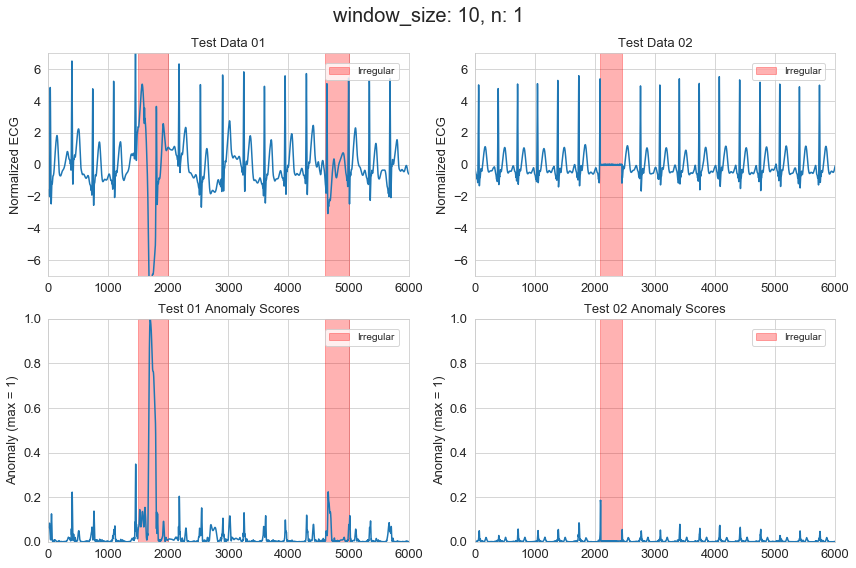

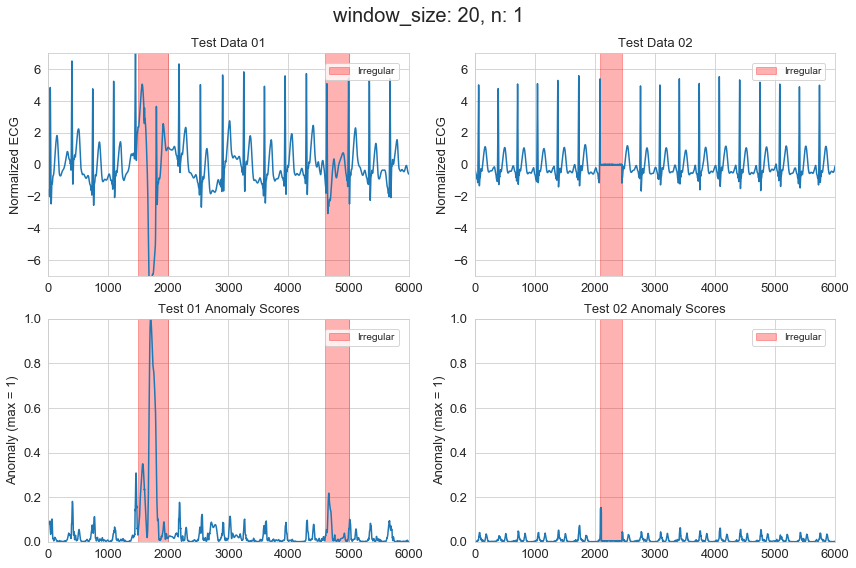

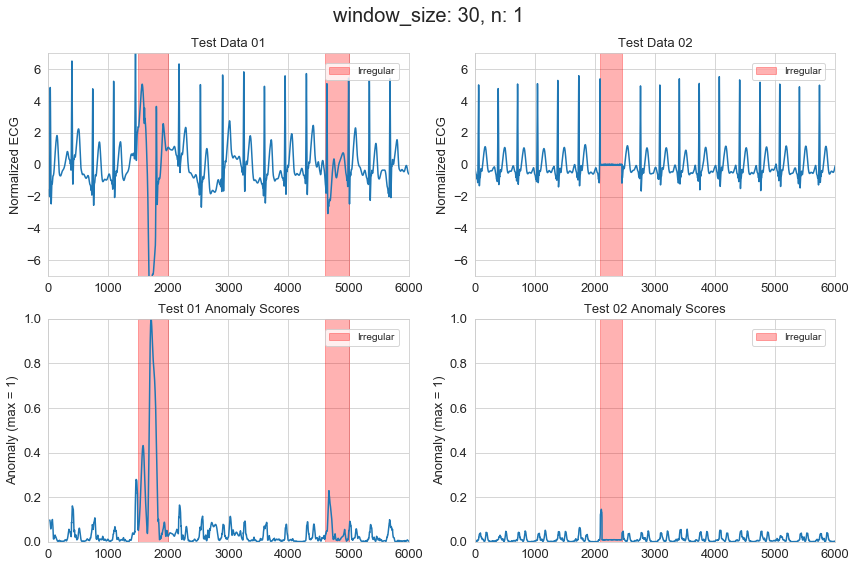

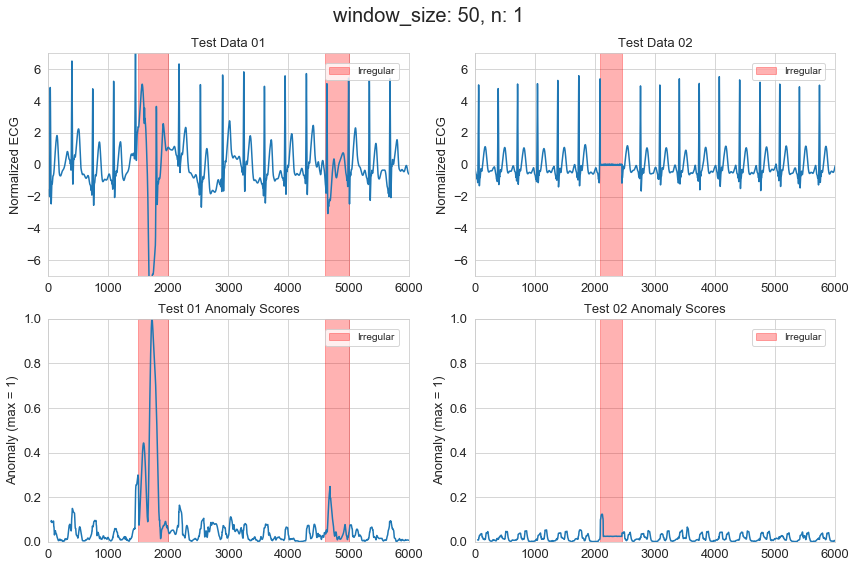

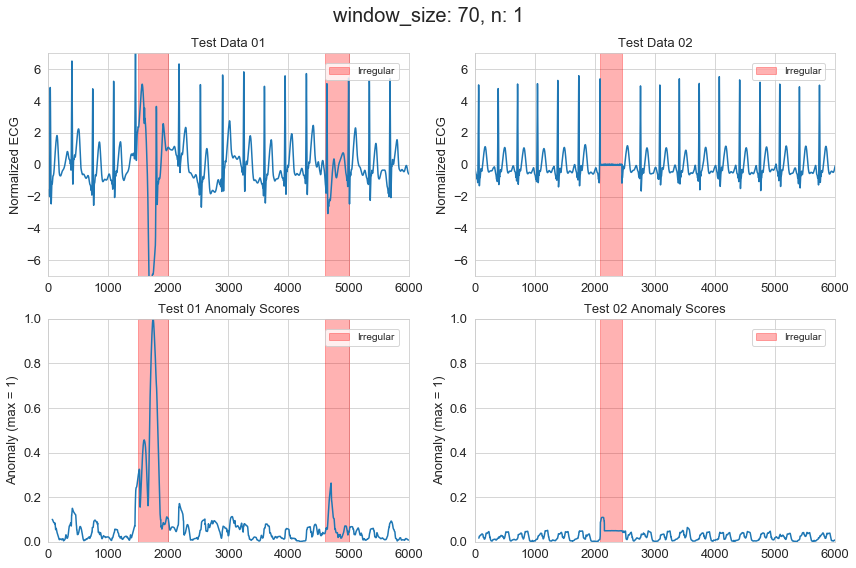

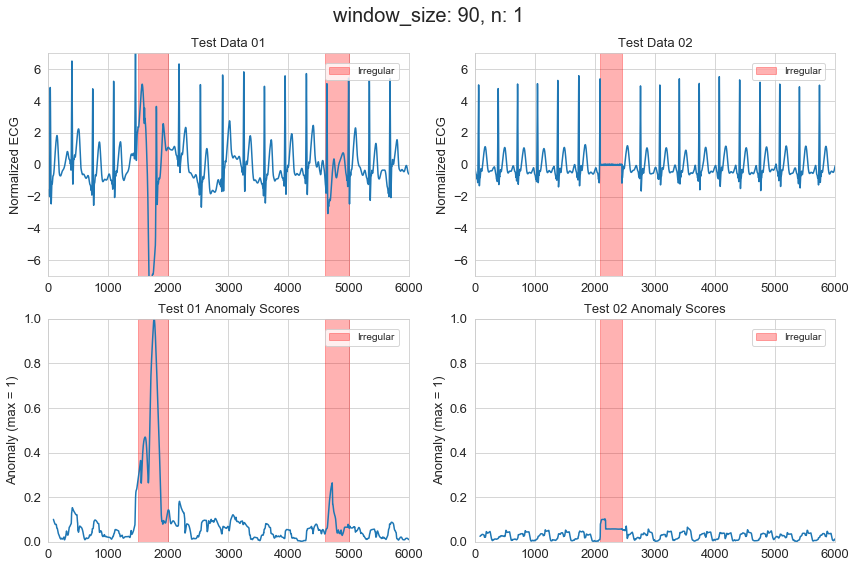

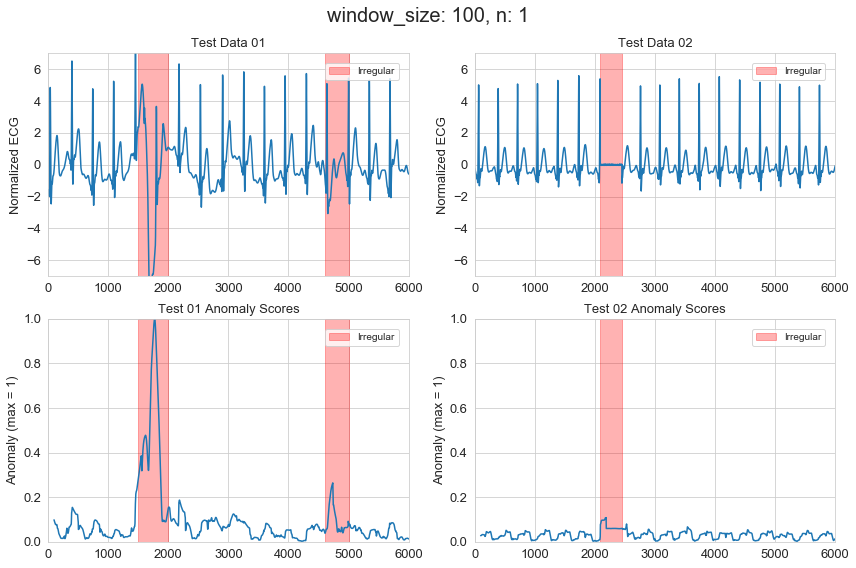

In [134]:
display_anomaly_score(test_01['ecg'].values, test_02['ecg'].values, test_01_anomaly, test_02_anomaly)

### AR Model

In [157]:
# Check the stationarity
adfuller(train['ecg'])

(-10.121429081456293,
 9.422547024154176e-18,
 34,
 5965,
 {'1%': -3.431446750429939,
  '5%': -2.8620246623524763,
  '10%': -2.5670279833887113},
 -65603.51806086782)

The data is stationary

In [158]:
# Choose the best lag using AIC
best_aic = 99 * (10**10)
best_lag = 0

for i in range(500):
    try:
        ar_model = AR(train['ecg'].values)
    
        ar_model_fit = ar_model.fit(maxlag=i)

        if ar_model_fit.aic < best_aic:
            best_aic = ar_model_fit.aic
            best_lag = i
  
    except:
        pass

print(f'best_aic = {best_aic}')
print(f'best_lag = {best_lag}')

best_aic = -14.139002939975283
best_lag = 79


In [73]:
# create model and calculate the anomaly socre
# model
ar_model = AR(train['ecg'].values)

# model fit with maxlag=79 from the AIC
ar_model_fit = ar_model.fit(maxlag=79)

# This model uses the last lagged 79 data points to predict
# window is the lag (79)
window = ar_model_fit.k_ar

coef = ar_model_fit.params


def ar_predictions(data):
    
    predictions = []
    history = []

    for idx, value in enumerate(data):

        # the model can predict after getting the data more than the window
        history.append(value)
        if len(history) < window:
            continue

        # predictions using the lagged data and coefficients
        length = len(history)
        lag = [history[i] for i in range(length - window, length)]
        yhat = coef[0]

        for d in range(window):
            yhat += coef[d+1] * lag[window - d - 1]

        predictions.append(yhat)
        
        return np.array(predictions)

# get predictions
test_1_pred = ar_predictions(test_01['ecg'].values)    
test_2_pred = ar_predictions(test_02['ecg'].values)

# observed data
test_1_observe = test_01['ecg'].values[window-1:]
test_2_observe = test_02['ecg'].values[window-1:]

# anomaly = (observation - prediction) ** 2
ar_anomaly_test_1 = (test_1_observe - test_1_pred) ** 2
ar_anomaly_test_2 = (test_2_observe - test_2_pred) ** 2

In [76]:
# normalization (max=1)
mx = np.max(ar_anomaly_test_1)
ar_anomaly_test_1 = ar_anomaly_test_1 / mx
ar_anomaly_test_2 = ar_anomaly_test_1 / mx

In [78]:
# match the original test data length and the anomaly score length
nan_list = [np.nan for _ in range(window - 1)]

ar_anomaly_test_1 = np.append(nan_list, ar_anomaly_test_1)
test_1_pred = np.append(nan_list, test_1_pred)

ar_anomaly_test_2 = np.append(nan_list, ar_anomaly_test_2)
test_2_pred = np.append(nan_list, test_2_pred)

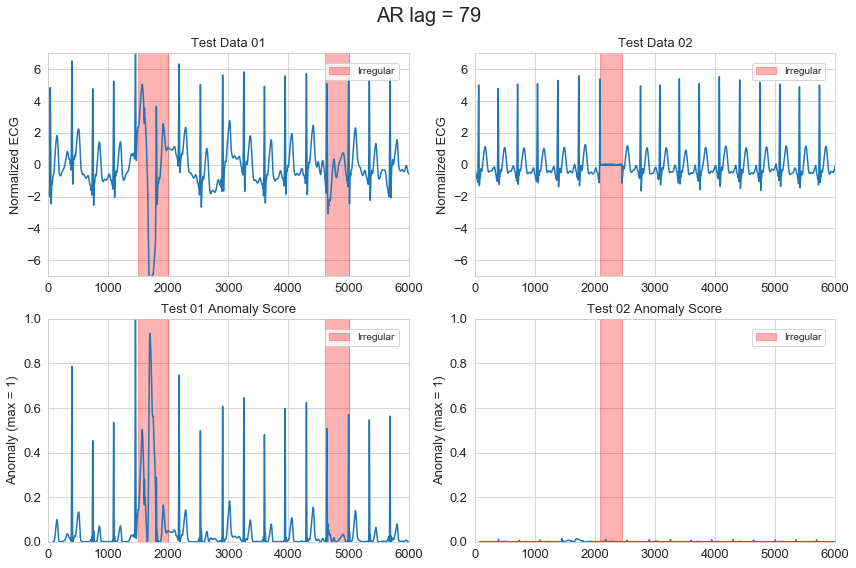

In [138]:
# plot the graph
fig, ax = plt.subplots(2, 2, figsize=(12, 8));
ax = ax.ravel()

# test_01
ax[0].plot(test_01['ecg'].values);
ax[0].set_title('Test Data 01', fontsize=13);
ax[0].set_xlim(0, 6000);
ax[0].set_ylim(-7, 7);
ax[0].set_ylabel('Normalized ECG', fontsize=13)

ax[0].axvspan(1500, 2000, color="red", alpha=0.3, label='Irregular');
ax[0].axvspan(4600, 5000, color="red", alpha=0.3);
ax[0].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1);

ax[0].tick_params(axis='x', labelsize=13)
ax[0].tick_params(axis='y', labelsize=13)

# test_02
ax[1].plot(test_02['ecg'].values);
ax[1].set_title('Test Data 02', fontsize=13);
ax[1].set_xlim(0, 6000);
ax[1].set_ylim(-7, 7);
ax[1].set_ylabel('Normalized ECG', fontsize=13)

ax[1].axvspan(2090, 2450, color="red", alpha=0.3, label='Irregular');
ax[1].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1);

ax[1].tick_params(axis='x', labelsize=13)
ax[1].tick_params(axis='y', labelsize=13)

# test_01 anomaly
ax[2].plot(ar_anomaly_test_1);
ax[2].set_title('Test 01 Anomaly Score', fontsize=13);
ax[2].set_xlim(0, 6000);
ax[2].set_ylim(0, 1);
ax[2].set_ylabel('Anomaly (max = 1)', fontsize=13)

ax[2].axvspan(1500, 2000, color="red", alpha=0.3, label='Irregular');
ax[2].axvspan(4600, 5000, color="red", alpha=0.3);
ax[2].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1);

ax[2].tick_params(axis='x', labelsize=13)
ax[2].tick_params(axis='y', labelsize=13)

# test_02 anomaly
ax[3].plot(ar_anomaly_test_2);
ax[3].set_title('Test 02 Anomaly Score', fontsize=13);
ax[3].set_xlim(0, 6000);
ax[3].set_ylim(0, 1);
ax[3].set_ylabel('Anomaly (max = 1)', fontsize=13)

ax[3].axvspan(2090, 2450, color="red", alpha=0.3, label='Irregular');
ax[3].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1);

ax[3].tick_params(axis='x', labelsize=13)
ax[3].tick_params(axis='y', labelsize=13)

plt.tight_layout();
fig.suptitle('AR lag = 79', fontsize=20);
plt.subplots_adjust(top=0.9);



### Singular Spectrum Analysis

The SSA functions below were adapted from [here](https://qiita.com/s_katagiri/items/d46448018fe2058d47da)

In [86]:
# SSA functions
def window(seq, n):
    """
    """
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result
def SSA_anom(test, traject, w, ncol_t, ncol_h, ns_t, ns_h,
             normalize=False):
    """
    Characterize time series by SSA
    ARGUMENTS:
    -------------------------------------------------
    test: array-like. partial time series to create test matrices
    tracject: array-like. partial time series to create trajectory matrices
    ns_h: the number of singular vectors from the trajectory
    ns_t: the number of singular vectors from the test matrices
    -------------------------------------------------
    RETURNS:
    3 elements tuple: 
        element 1: anomaly socres
        element 2, 3: cumulative contribution rates for the test and the traject0ry matrices
    """
    H_test = np.array(
        tuple(x[:ncol_t] for x in window(test, w))[:w]
    )  # test matrix
    H_hist = np.array(
        tuple(x[:ncol_h] for x in window(traject, w))[:w]
    )  # trajectory matrix
    if normalize:
        H_test = (H_test - H_test.mean(axis=0,
                                       keepdims=True)) / H_test.std(axis=0)
        H_hist = (H_hist - H_hist.mean(axis=0,
                                       keepdims=True)) / H_hist.std(axis=0)
    Q, s1 = np.linalg.svd(H_test)[0:2]
    Q = Q[:, 0:ns_t]
    ratio_t = sum(s1[0:ns_t]) / sum(s1)
    U, s2 = np.linalg.svd(H_hist)[0:2]
    U = U[:, 0:ns_h]
    ratio_h = sum(s2[0:ns_t]) /sum(s2)
    anom = 1 - np.linalg.svd(np.matmul(U.T, Q),
                                     compute_uv=False
                                    )[0]
    return (anom, ratio_t, ratio_h)

def SSA_CD(series, w, lag,
           ncol_h=None, ncol_t=None,
           ns_h=None, ns_t=None,
           standardize=False, normalize=False, fill=True):
    """
    Change Detection by Singular Spectrum Analysis
    -------------------------------------------------
    w   : window width (= row width of matrices) 
    lag : default=round(w / 4)  Lag among 2 matrices 
    ncol_h: the number of the trajectory matrices columns
    ncol_t: the number of the test matrices columns
    ns_h: the number of singular vectors from the trajectory matrices. default=1
    ns_t: the number of singular vectors from the test matrices. default=1 
    standardize: standardize anomaly scores
    fill: match the anomaly socores length with the original data
    -------------------------------------------------
    Returns
    list:3 elements list: 
        element 1: anomaly socres
        element 2, 3: cumulative contribution rates for the test and the traject0ry matrices
    """
    if ncol_h is None:
        ncol_h = round(w / 2)
    if ncol_t is None:
        ncol_t = round(w / 2)
    if ns_h is None:
        ns_h = np.min([1, ncol_h])
    if ns_t is None:
        ns_t = np.min([1, ncol_t])
    if min(ncol_h, ncol_t) > w:
        print('ncol and ncol must be <= w')
    if ns_h > ncol_h or ns_t > ncol_t:
        print('I recommend to set ns_h >= ncol_h and ns_t >= ncol_t')
    start_at = lag + w + ncol_h
    end_at = len(series) + 1
    res = []
    for t in range(start_at, end_at):
        res = res + [SSA_anom(series[t - w - ncol_t:t],
                              series[t - lag - w - ncol_h:t - lag],
                              w=w, ncol_t=ncol_t, ncol_h=ncol_h,
                              ns_t=ns_t, ns_h=ns_h,
                              normalize=normalize)]
    anom = [round(x, 14) for x, r1, r2 in res]
    ratio_t = [r1 for x, r1, r2 in res]
    ratio_h = [r2 for x, r1, r2 in res]
    if fill == True:
        anom = [np.nan] * (start_at - 1) + anom
    if standardize:
        c = np.nansum(anom)
        if c != 0:
            anom = [x / c for x in anom]
    return [anom, ratio_t, ratio_h]

In [87]:
def ssa_anomaly_calc(data):
    # try some parameters
    window_size = [10, 30, 50, 70, 90, 100]
    lag_size = [10, 25, 50]
    ns_h = [1, 2, 3]
    
    ssa_anomaly_scores = []

    for w_size in window_size:
        for l_size in lag_size:
            for s in ns_h:
                ssa_anomaly = SSA_CD(series=data, standardize=False, w=w_size, lag=l_size, ns_h=s, ns_t=1)

                data_dict = {'param_details': f'window: {w_size}, lag: {l_size} ns_h: {s}', 'anomaly': ssa_anomaly[0]}

                ssa_anomaly_scores.append(data_dict)
    
    return ssa_anomaly_scores

In [88]:
ssa_anom_test_1 = ssa_anomaly_calc(test_01['ecg'].values)
ssa_anom_test_2 = ssa_anomaly_calc(test_02['ecg'].values)

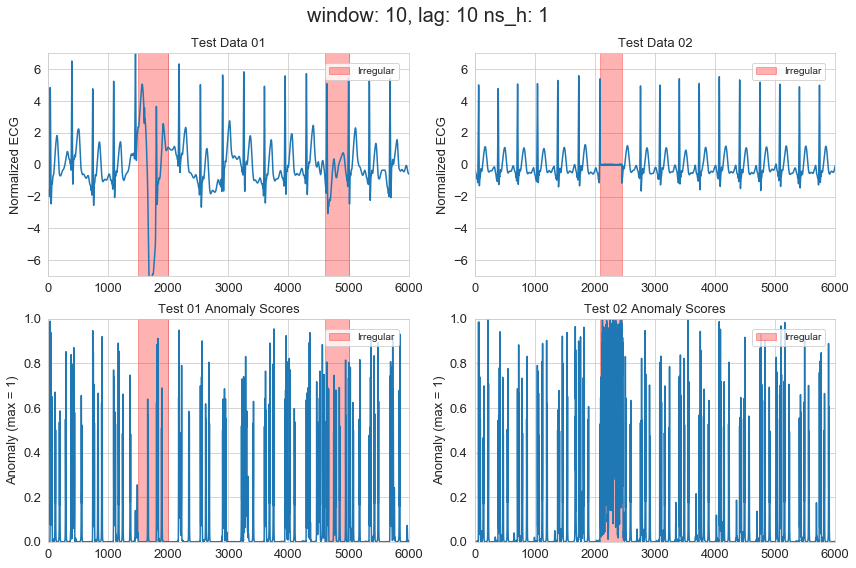

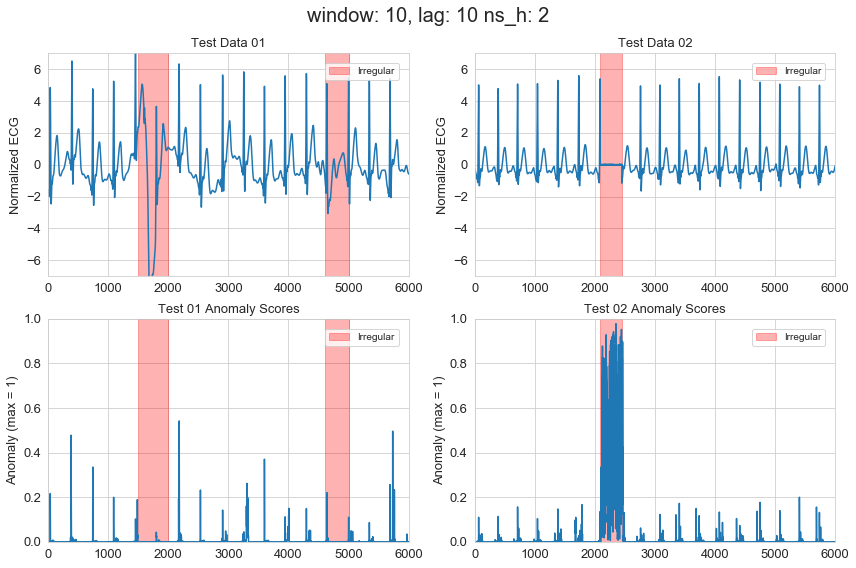

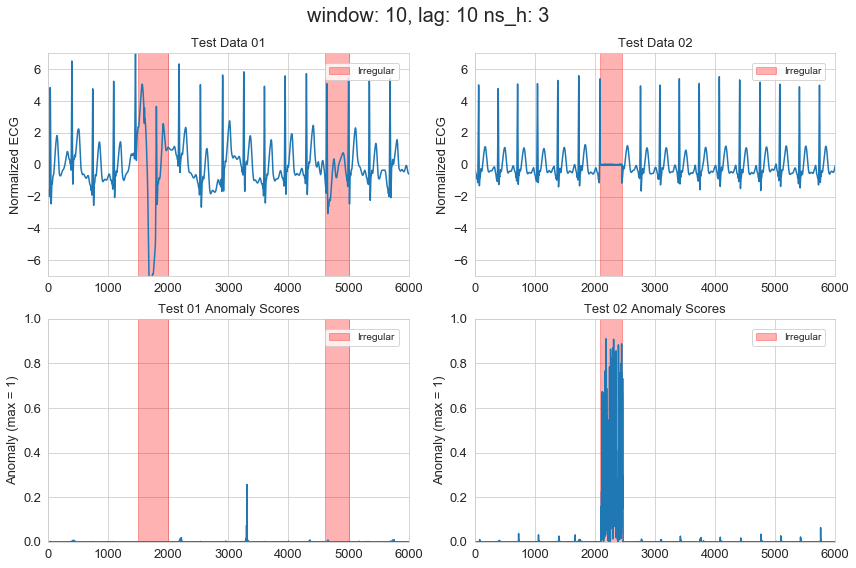

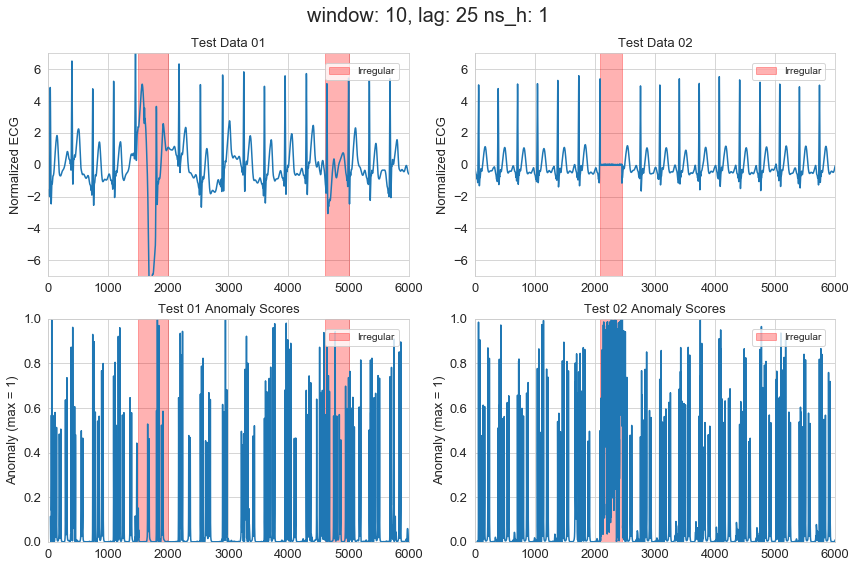

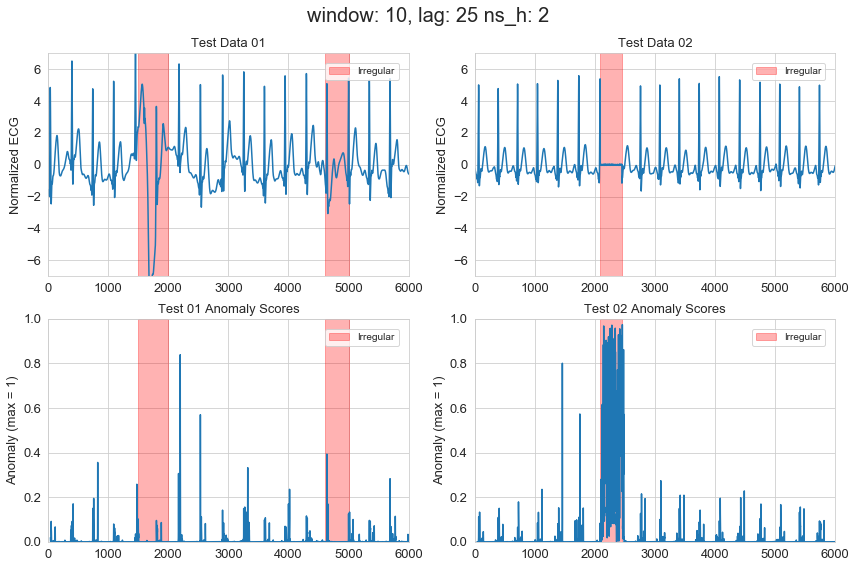

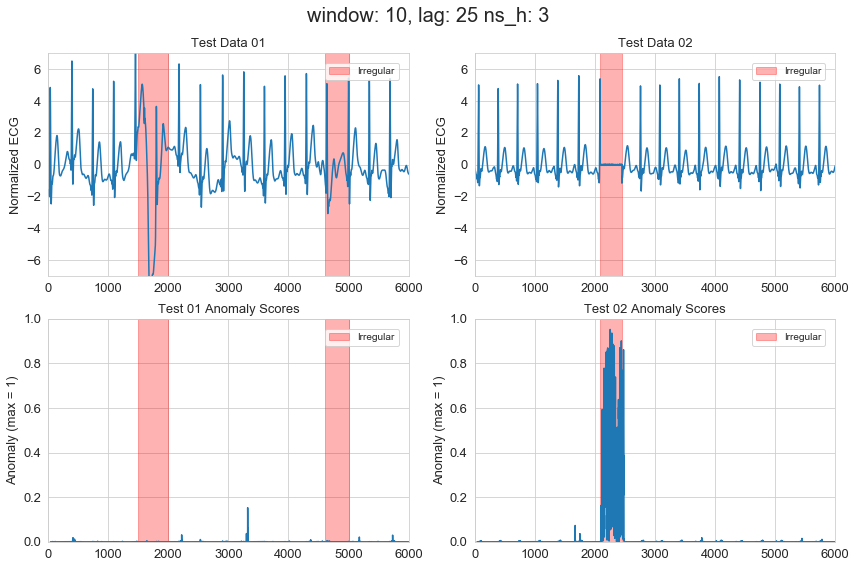

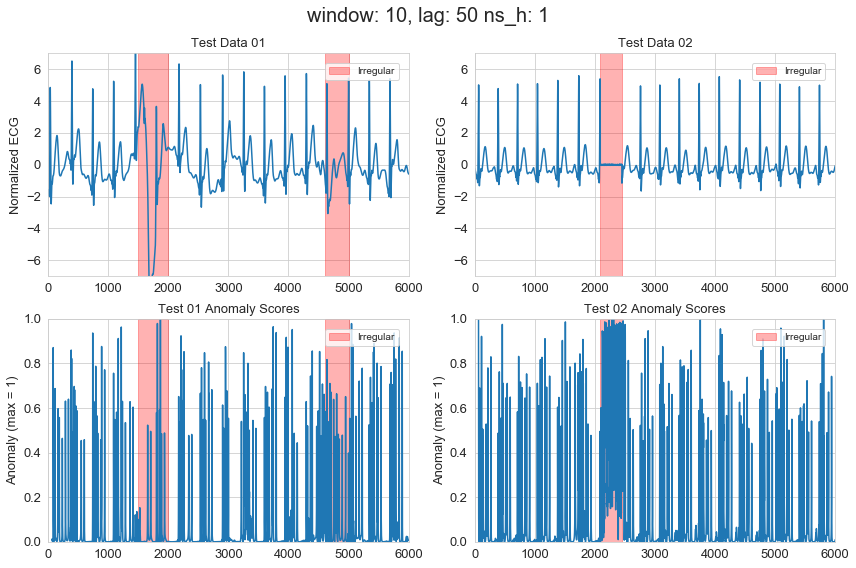

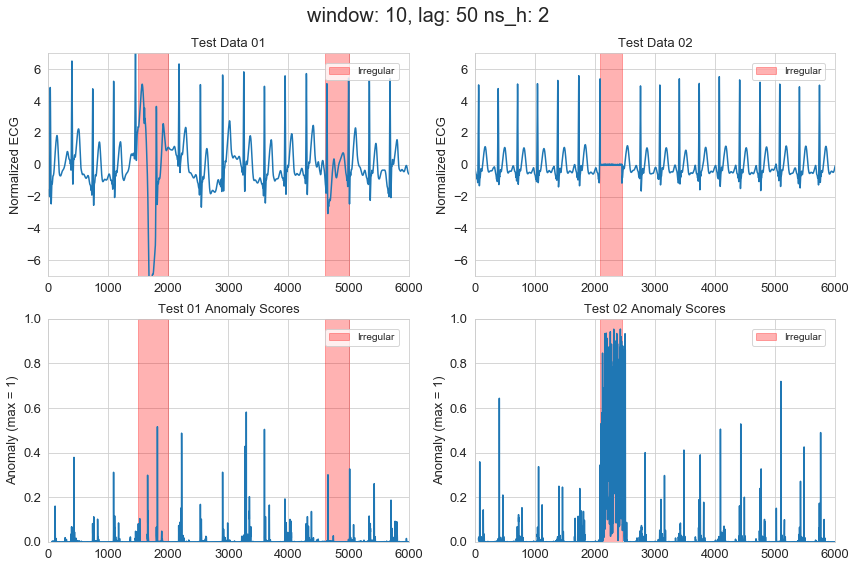

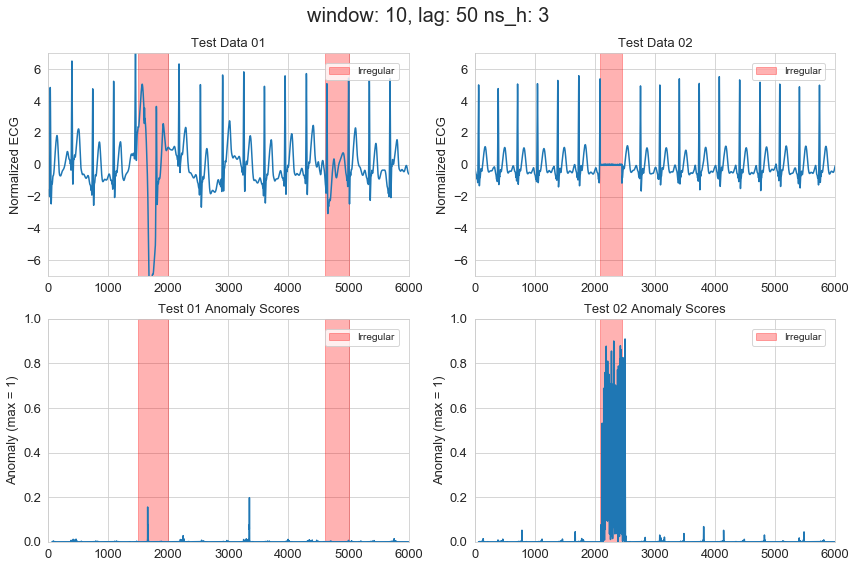

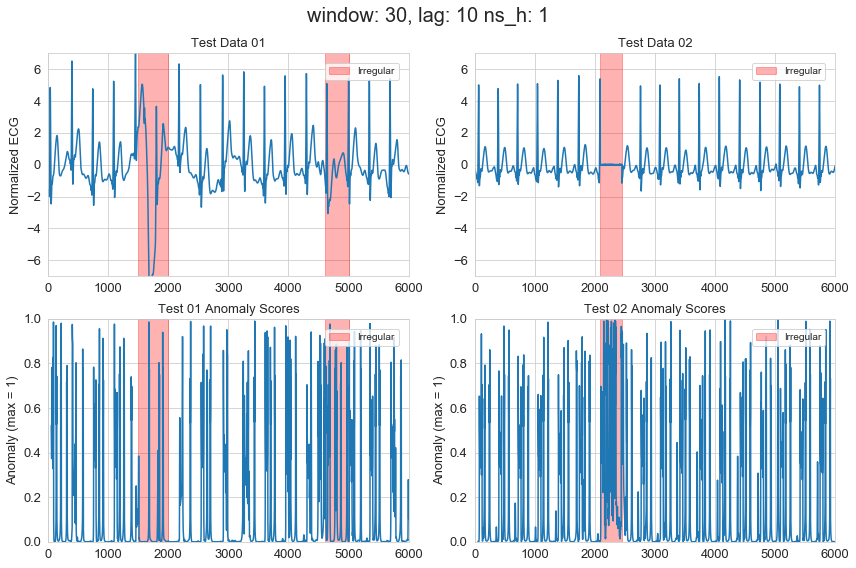

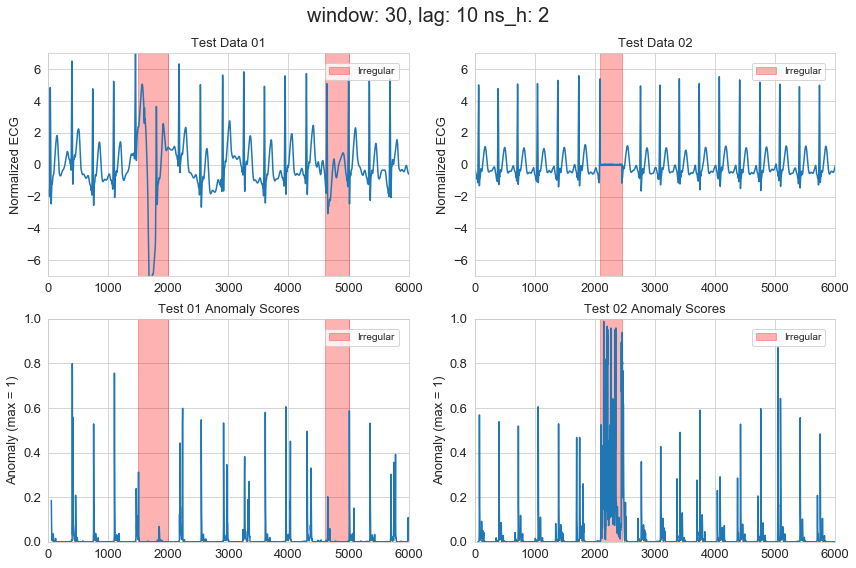

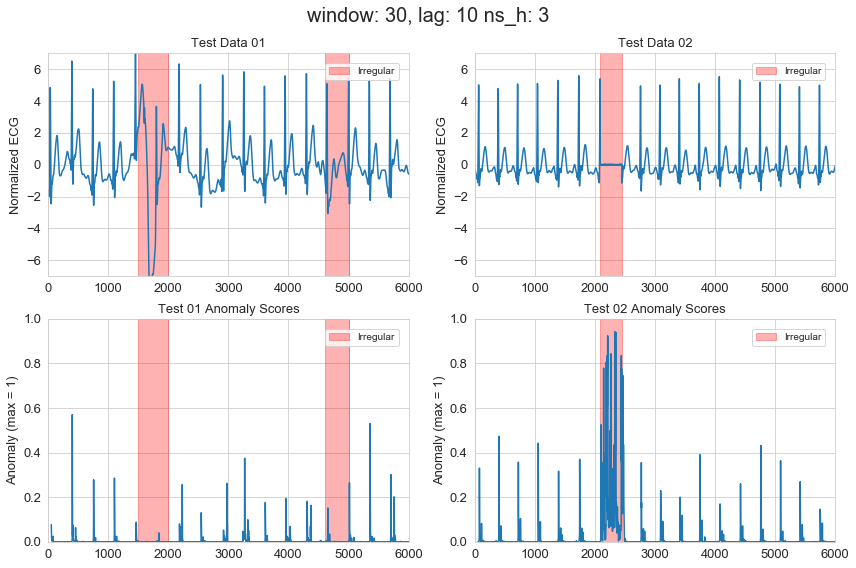

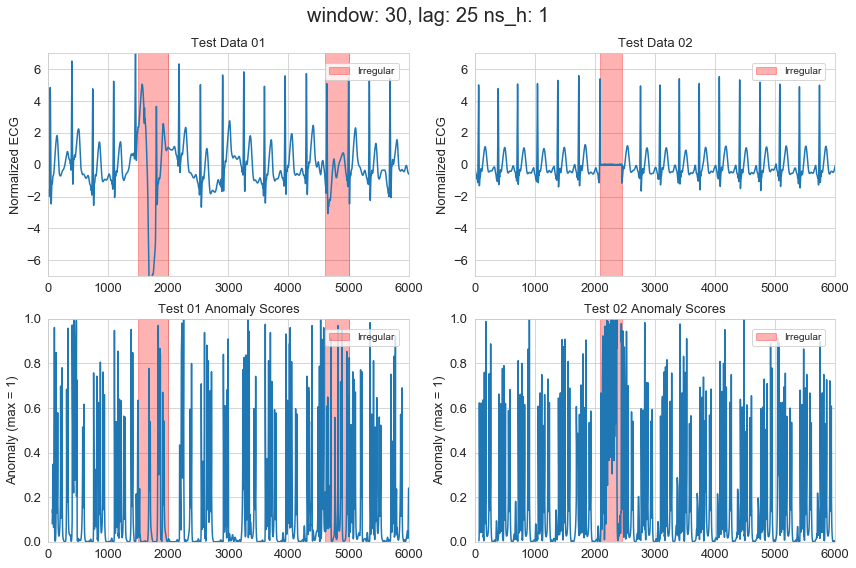

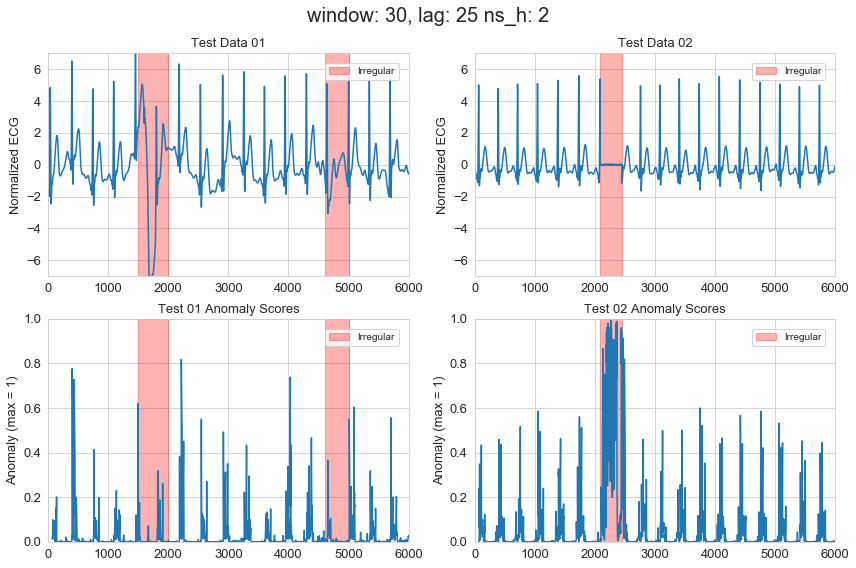

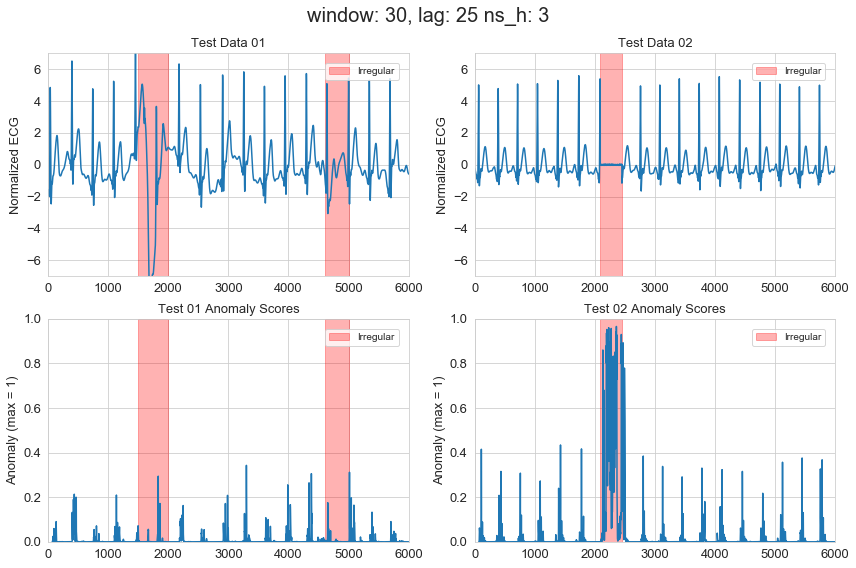

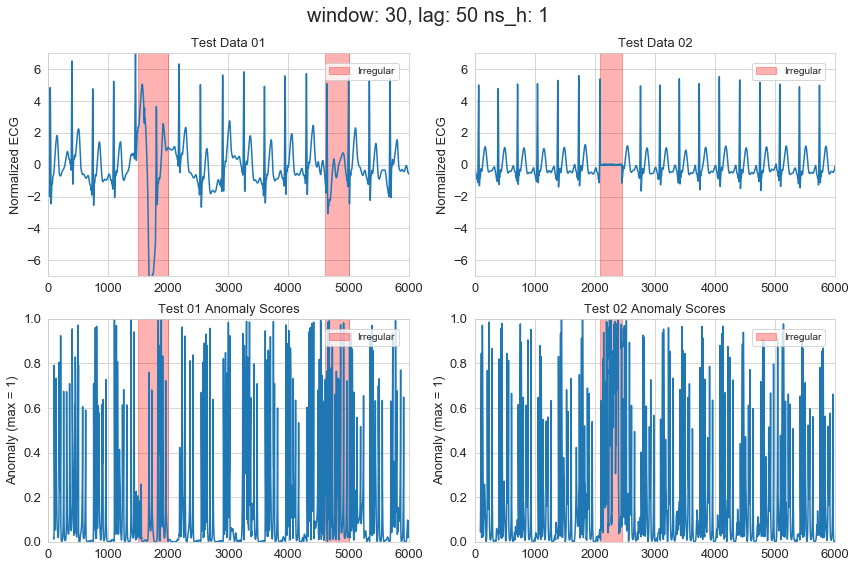

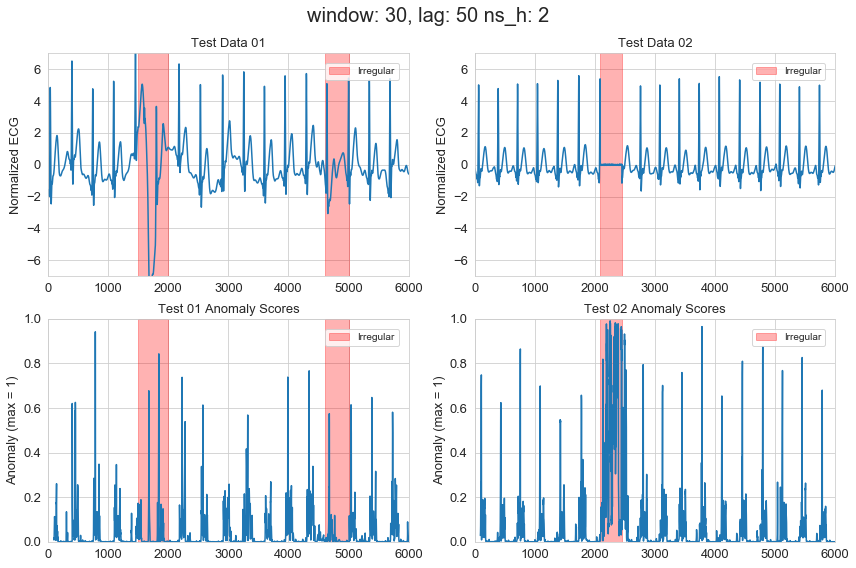

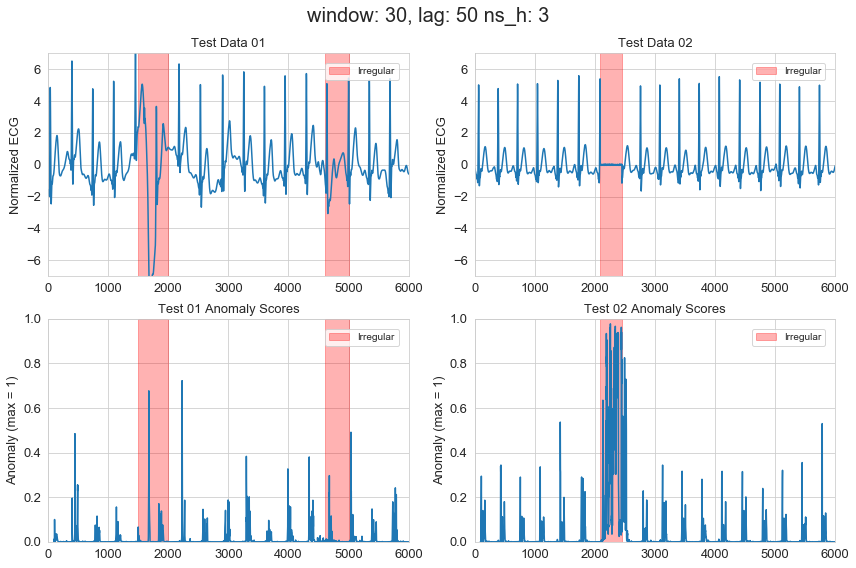

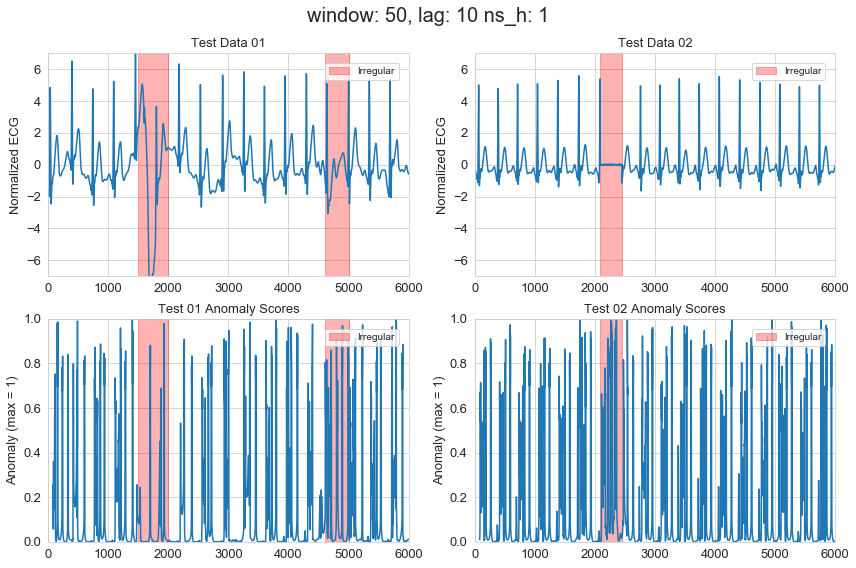

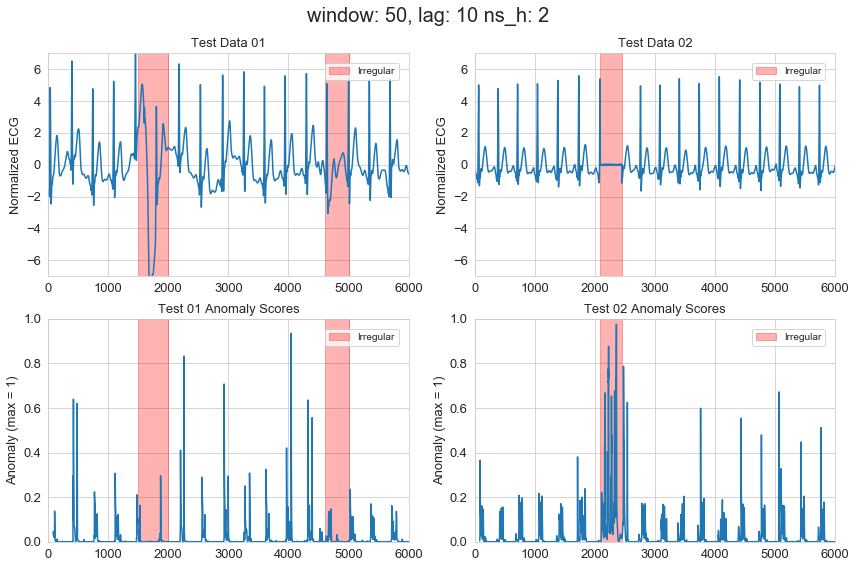

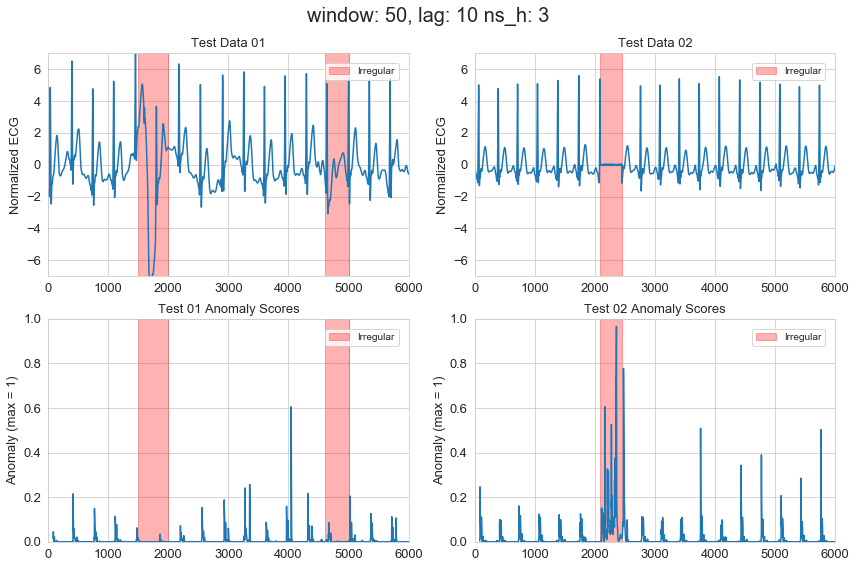

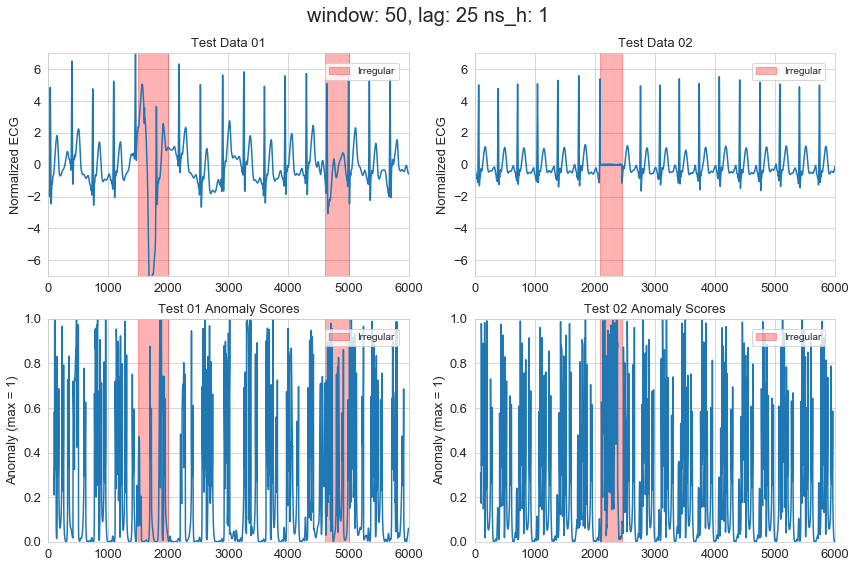

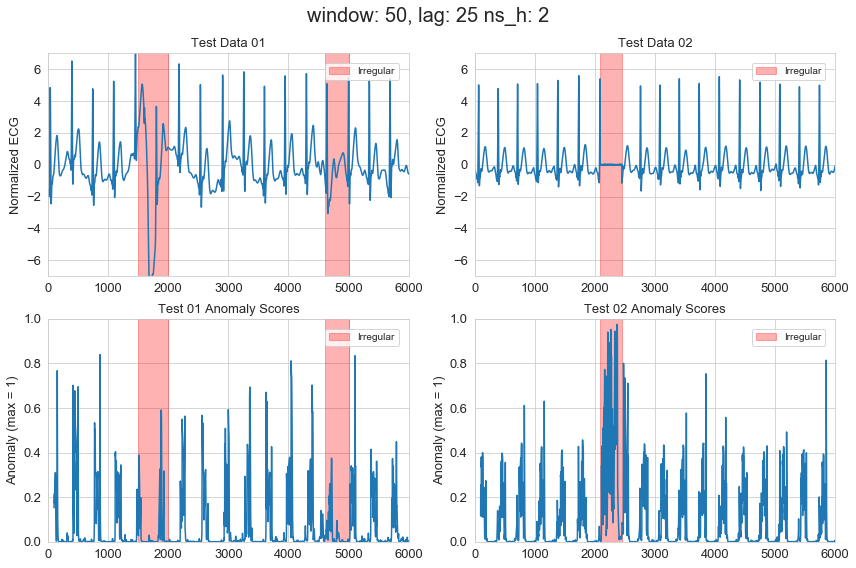

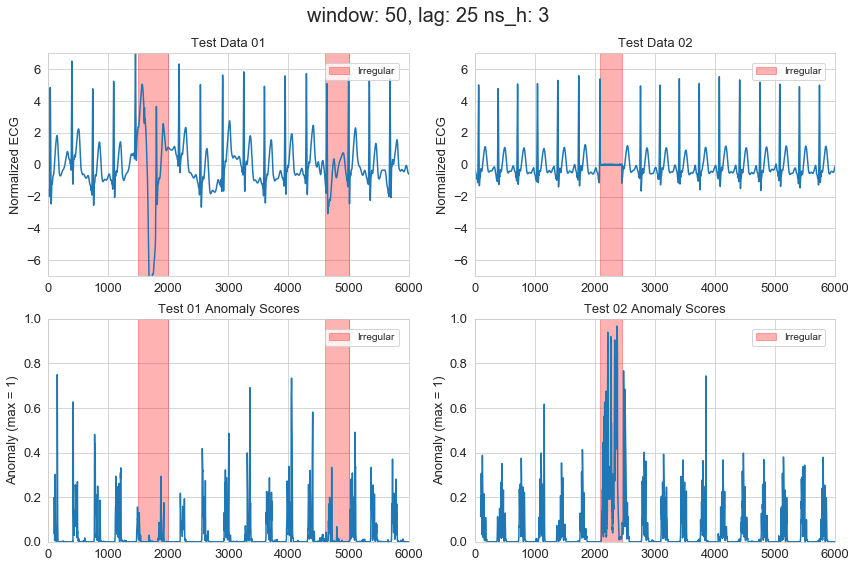

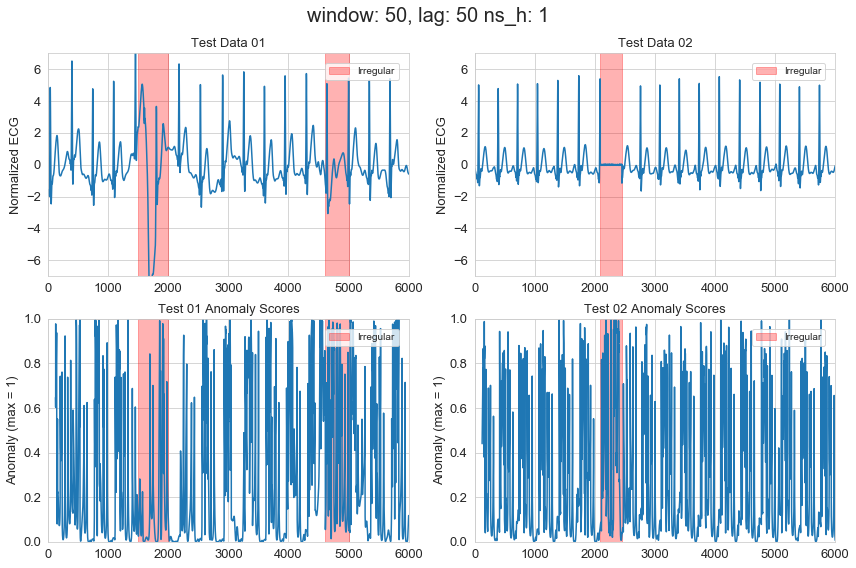

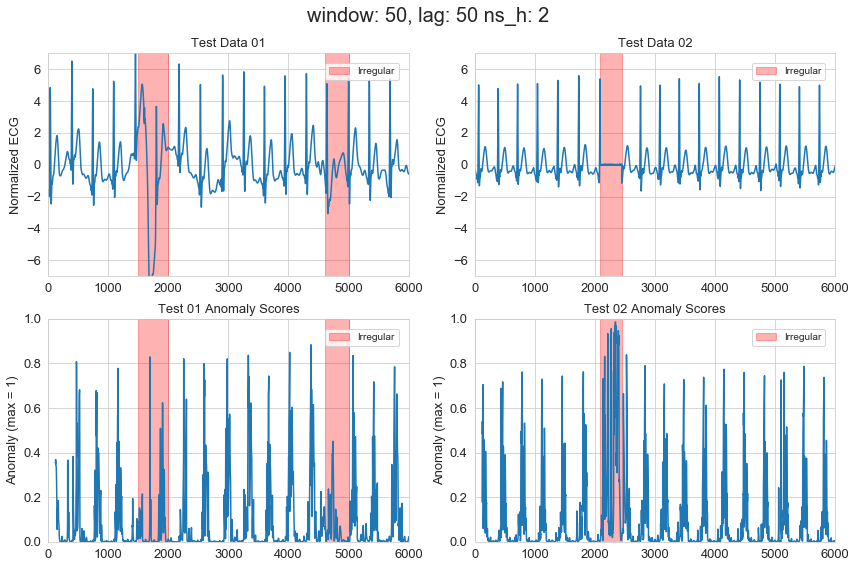

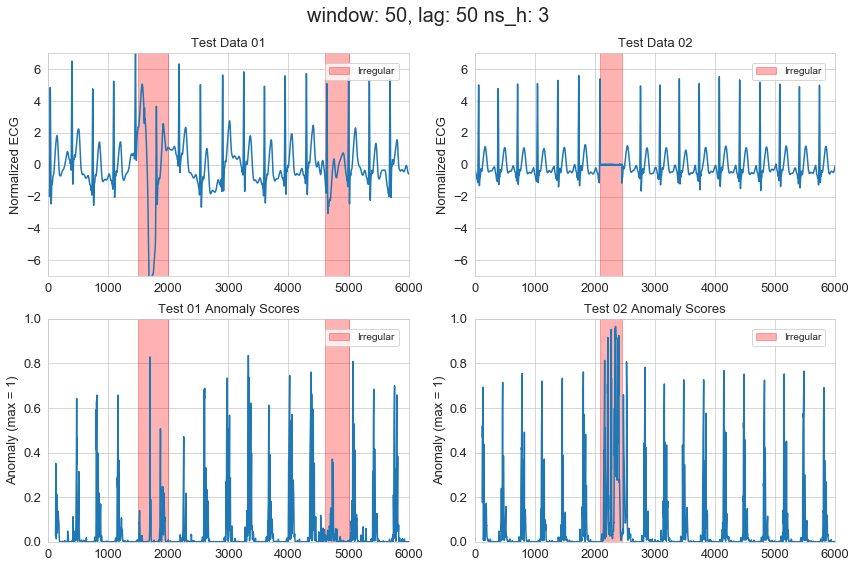

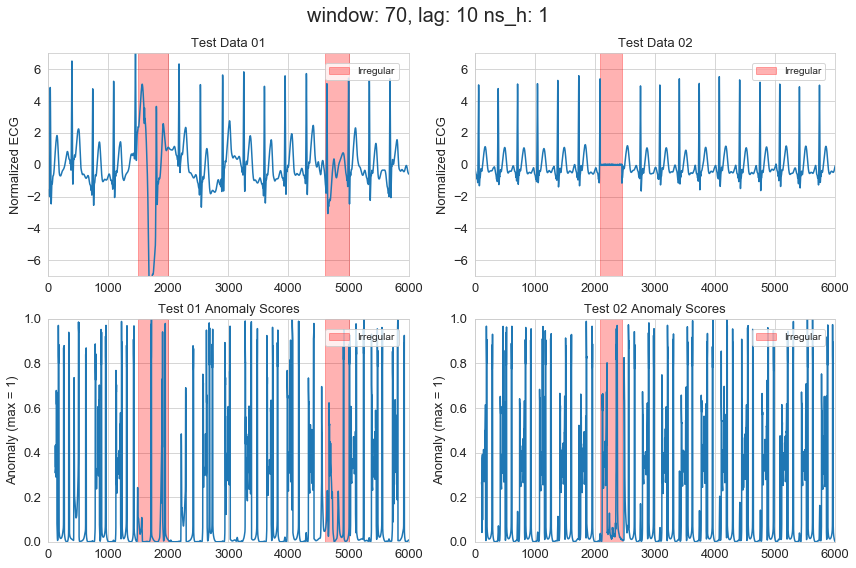

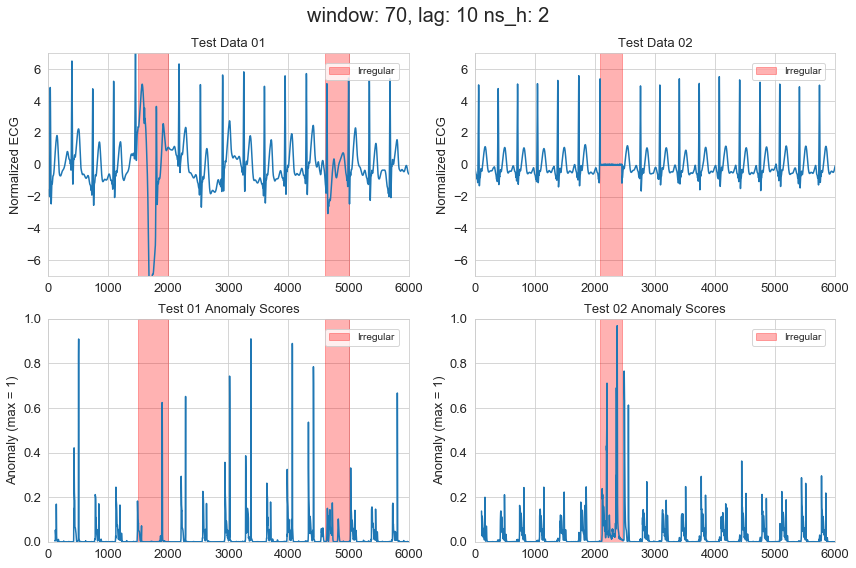

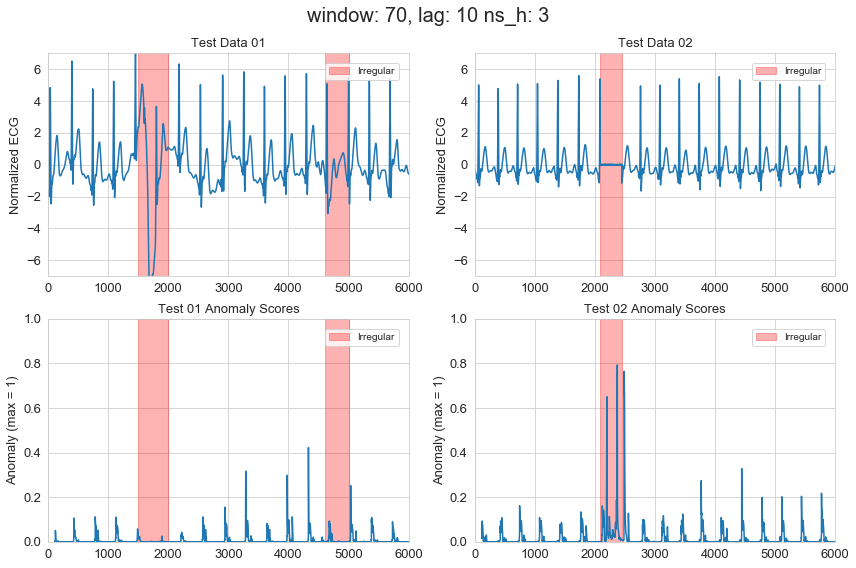

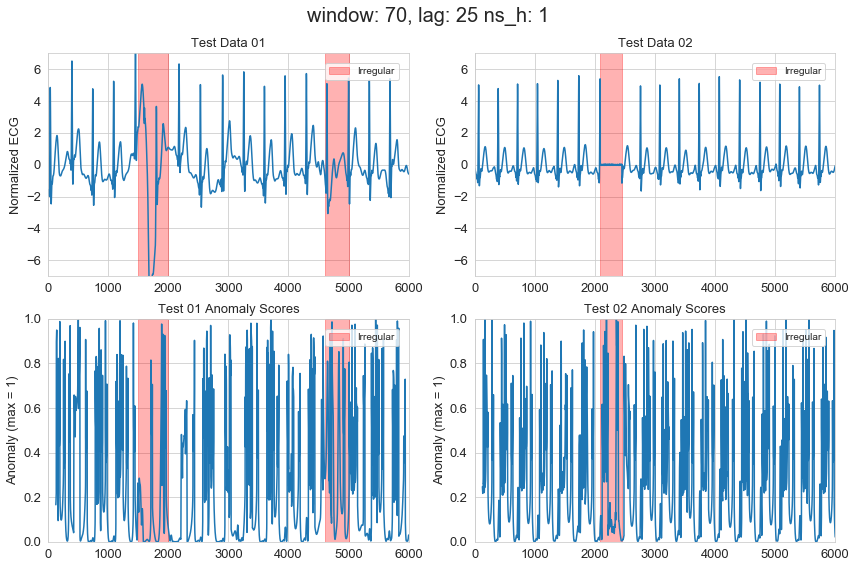

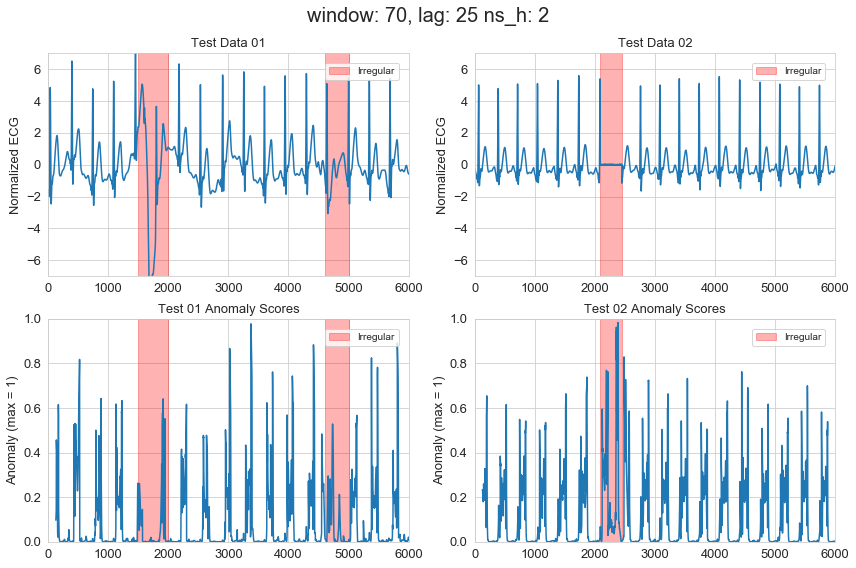

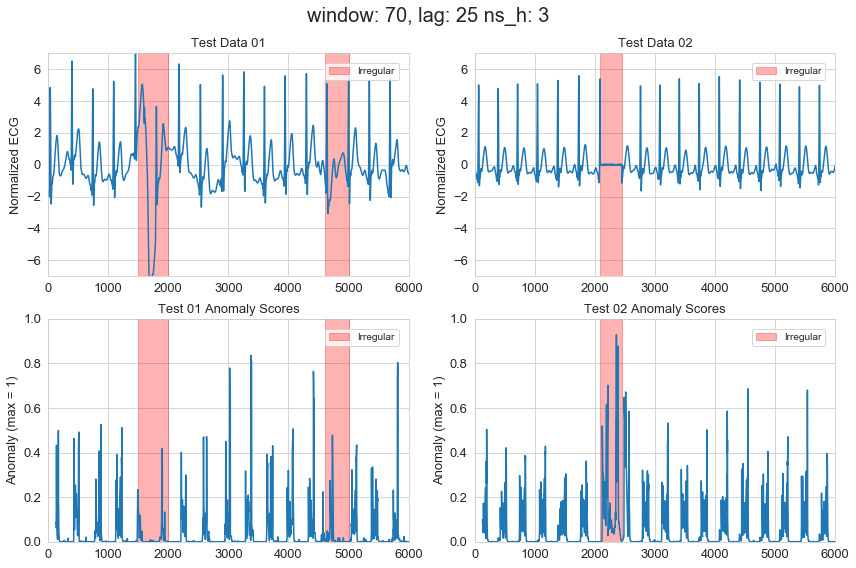

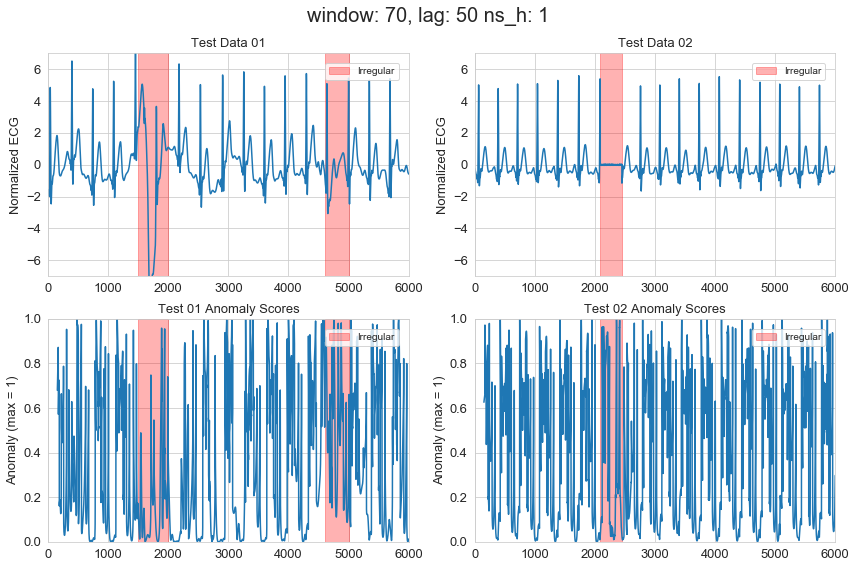

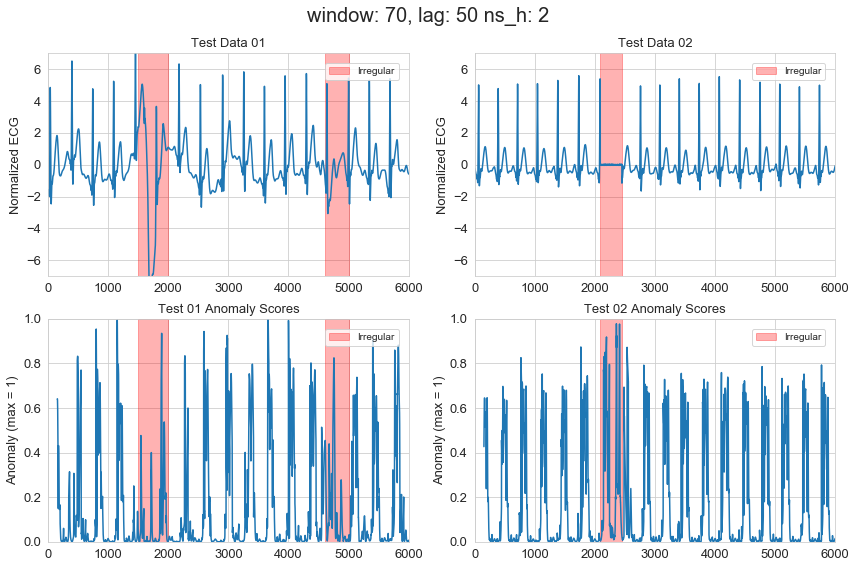

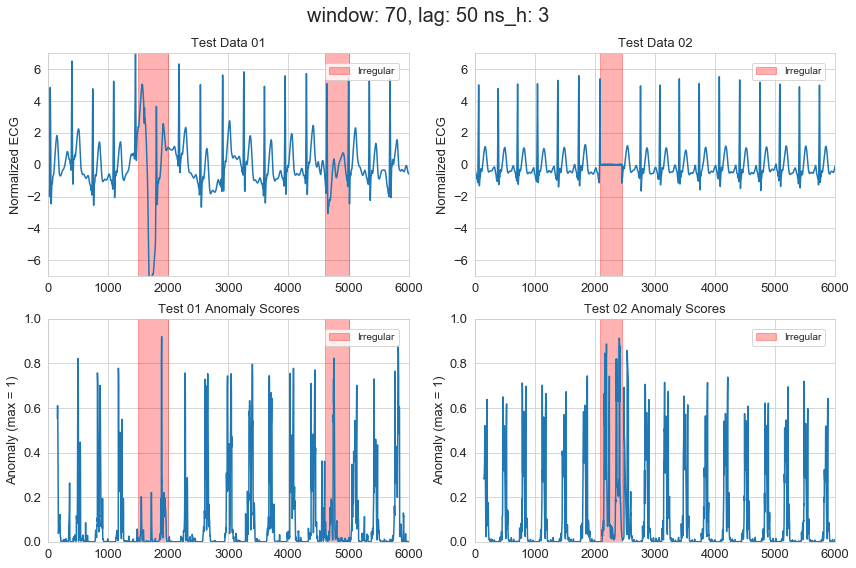

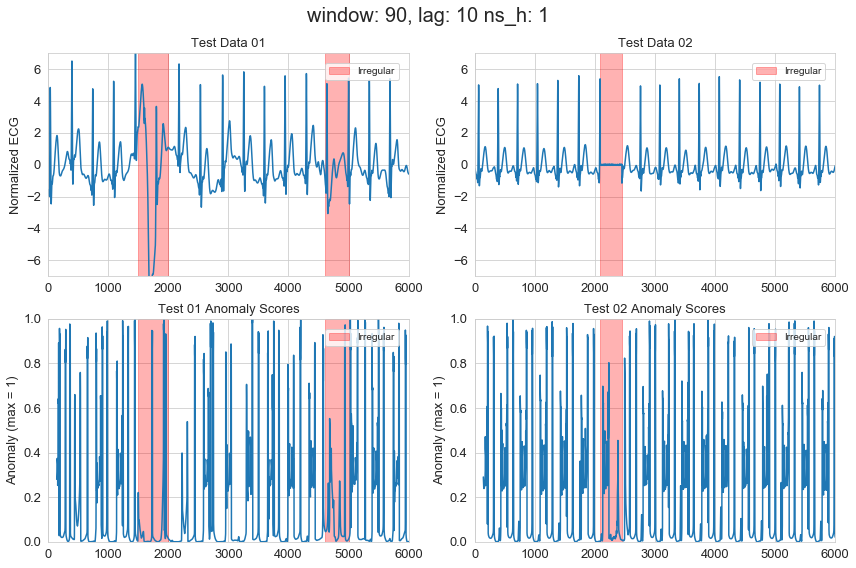

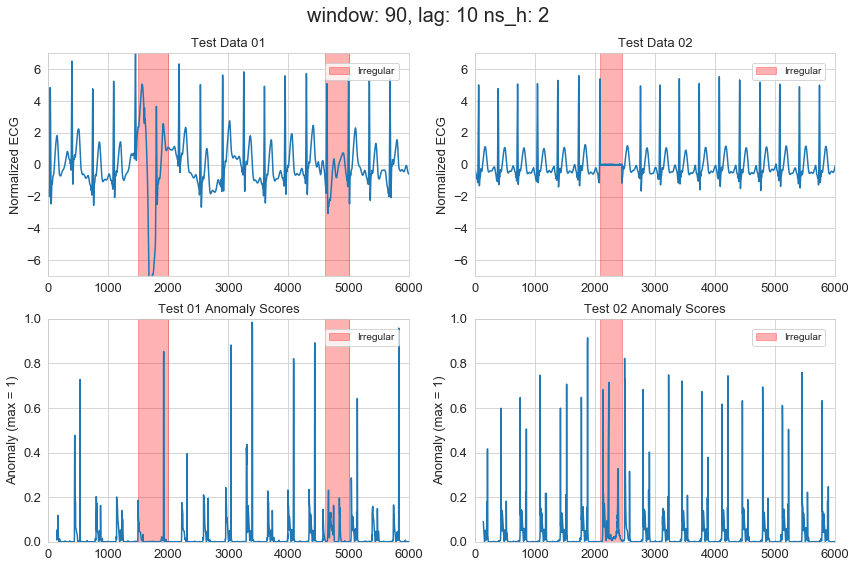

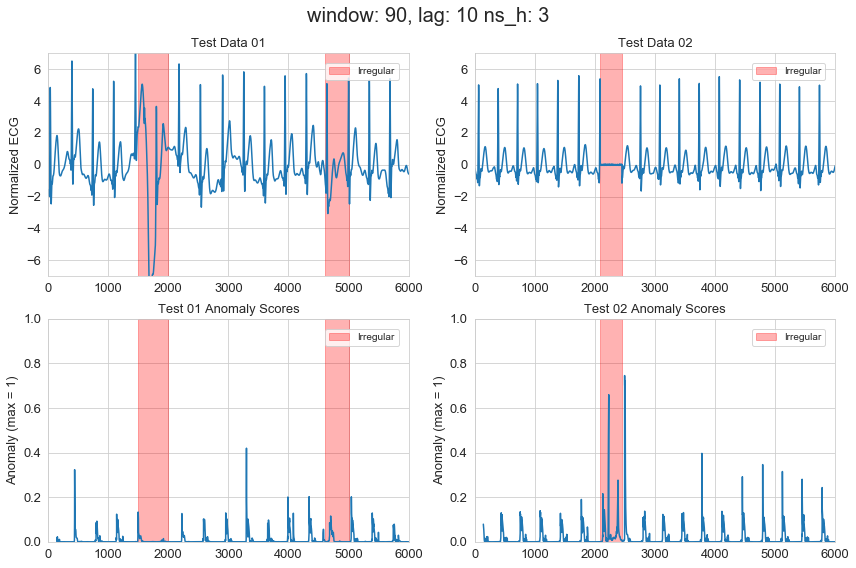

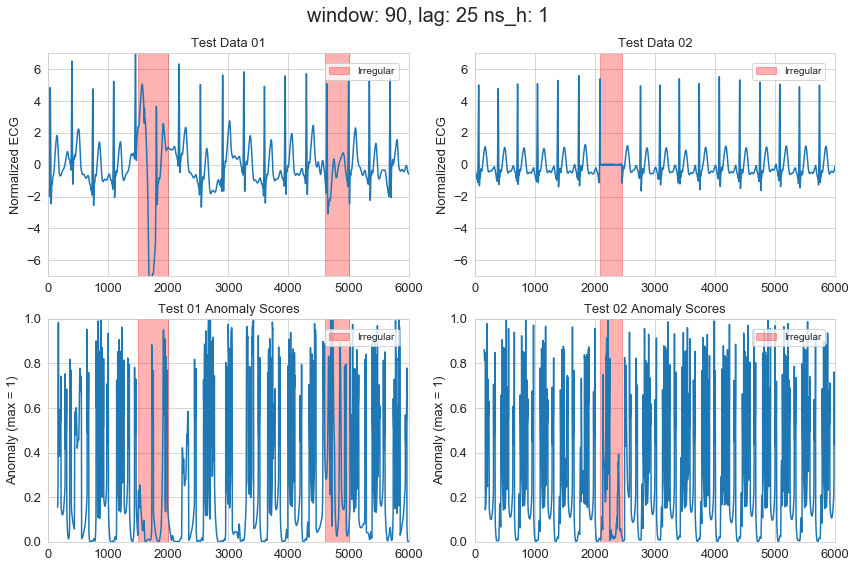

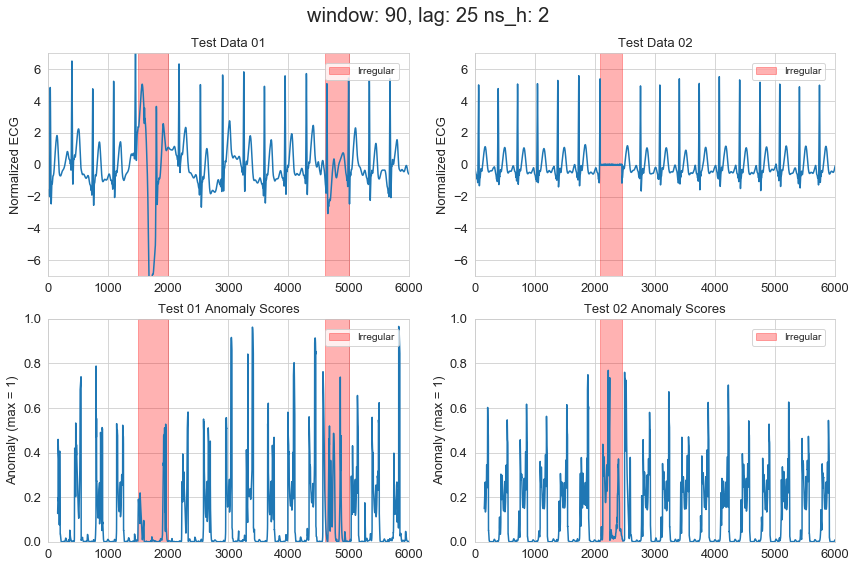

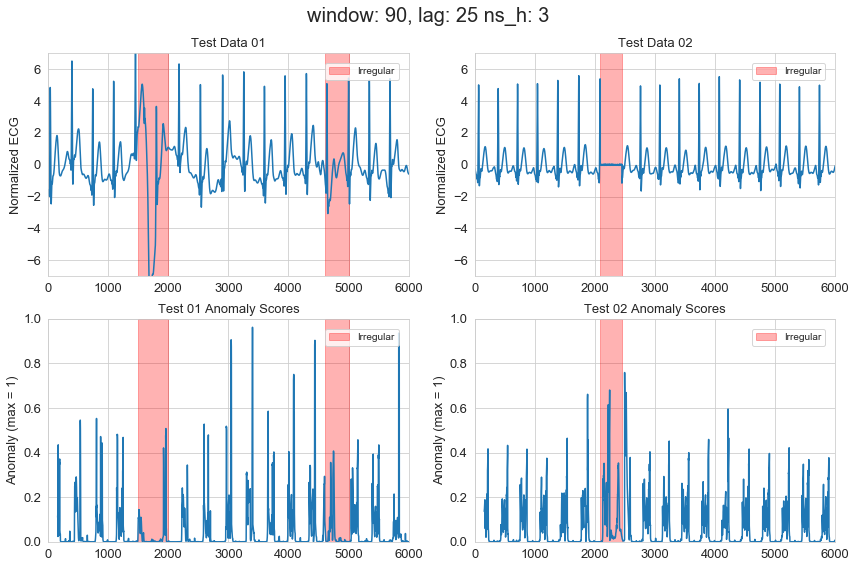

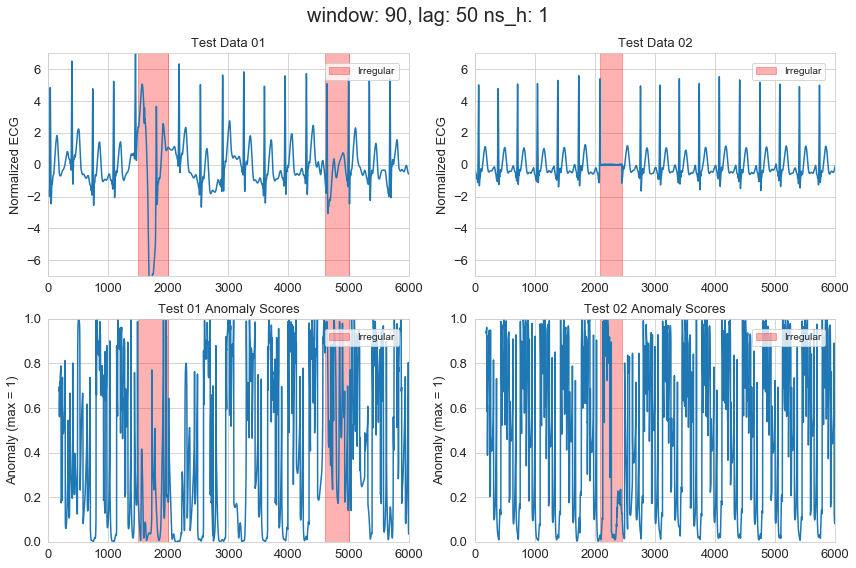

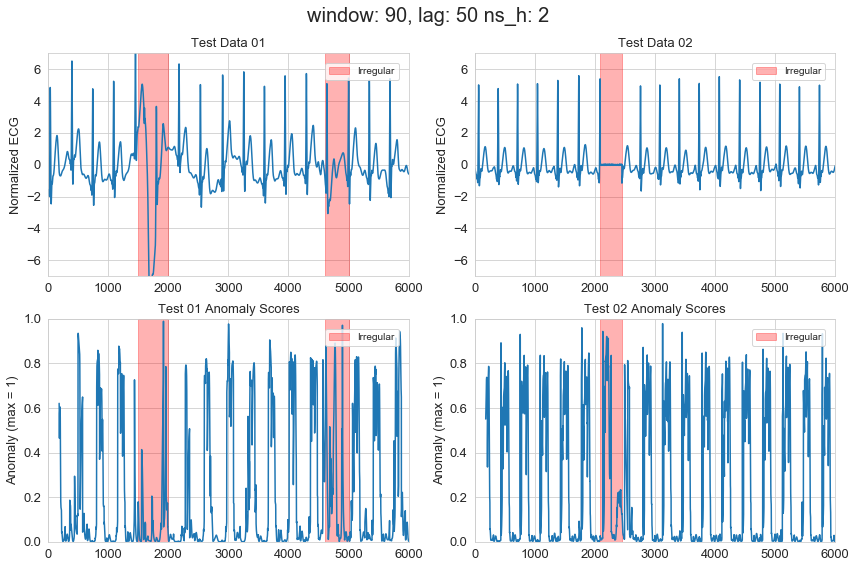

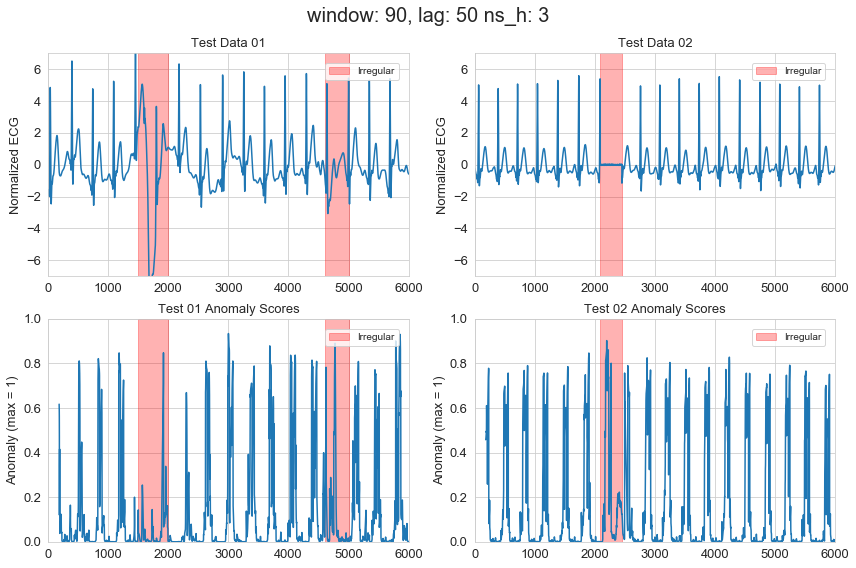

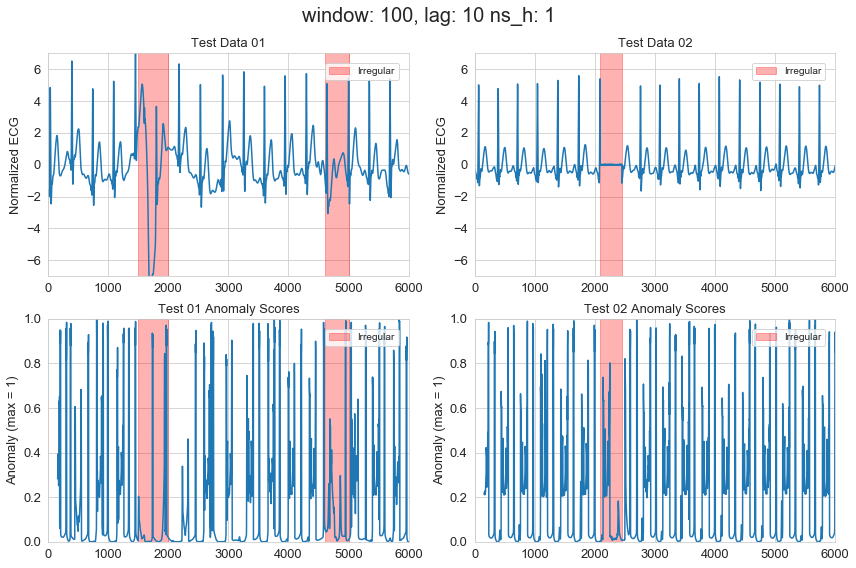

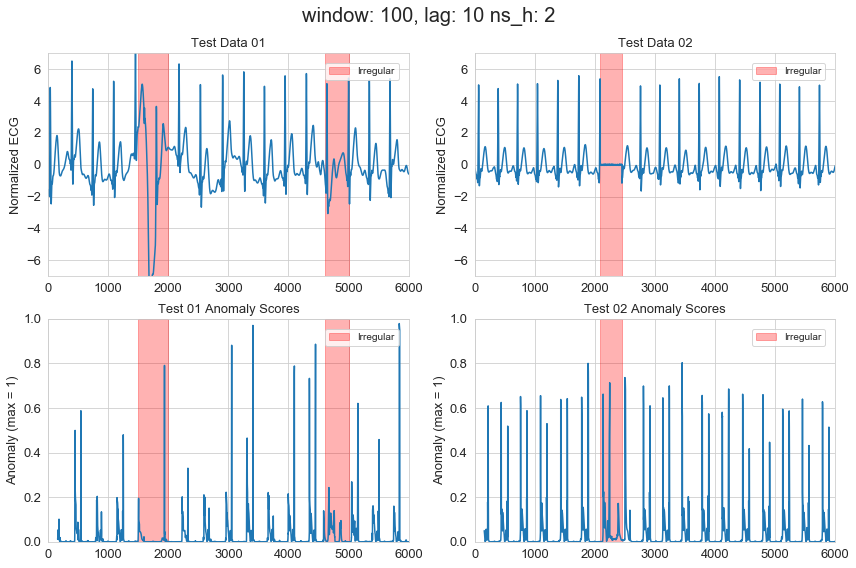

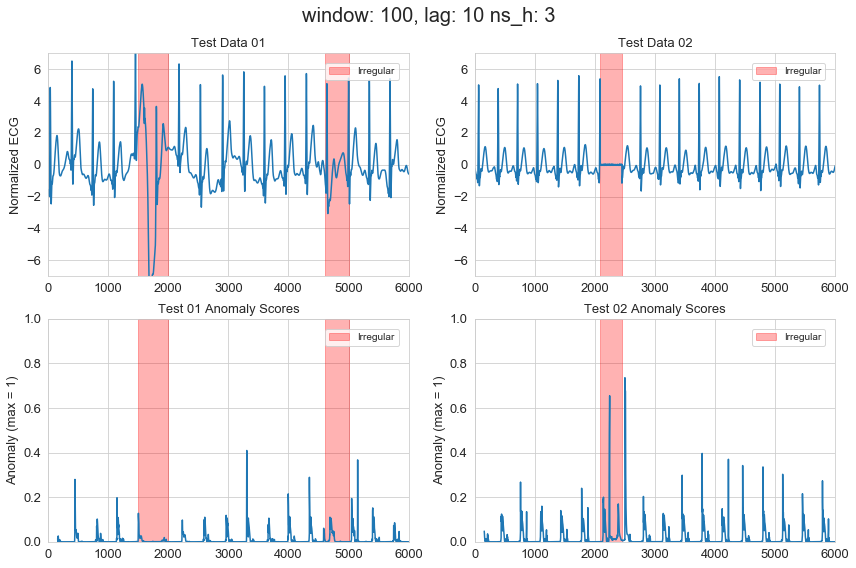

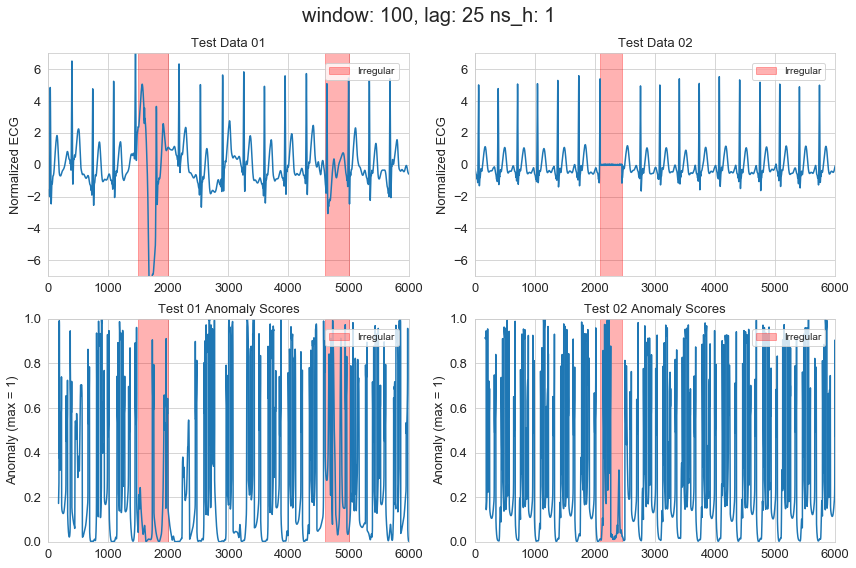

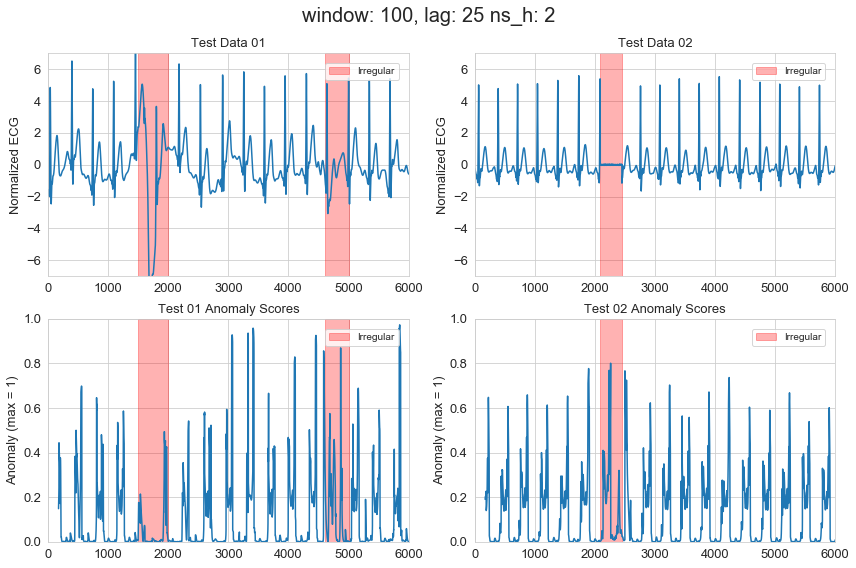

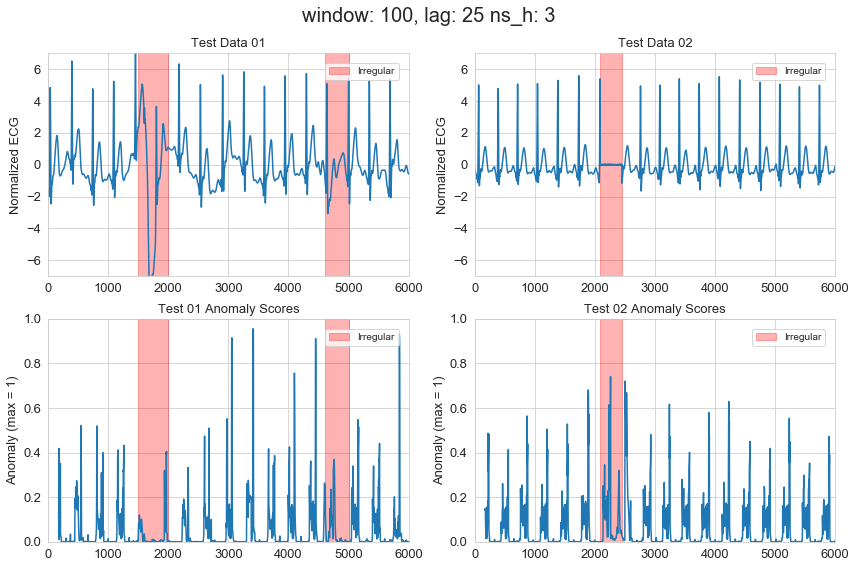

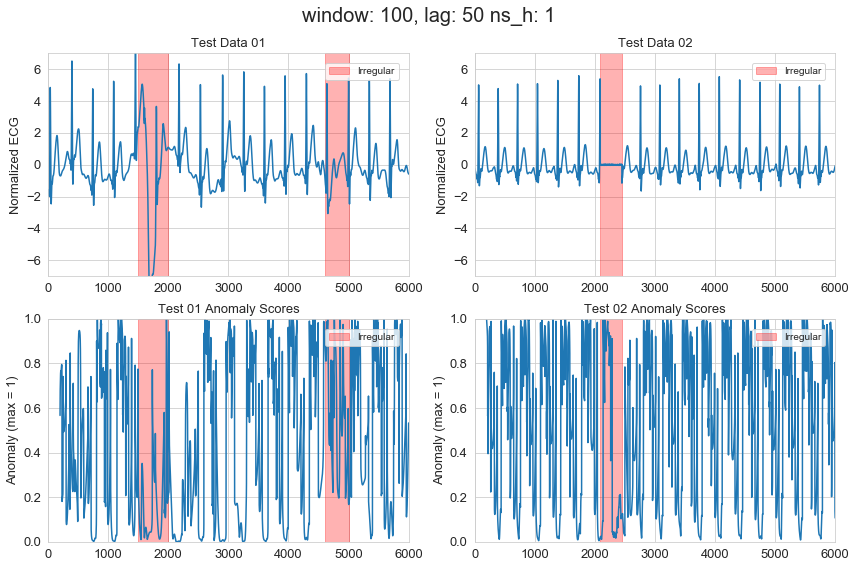

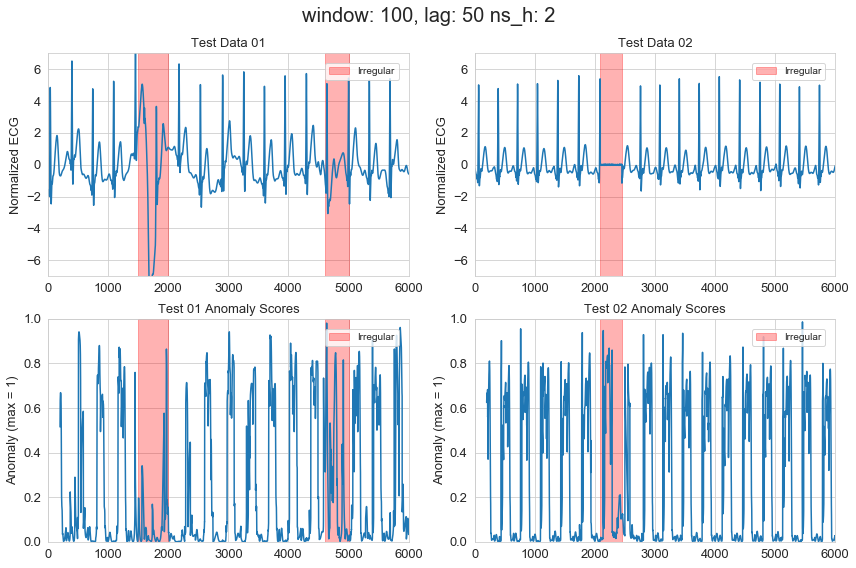

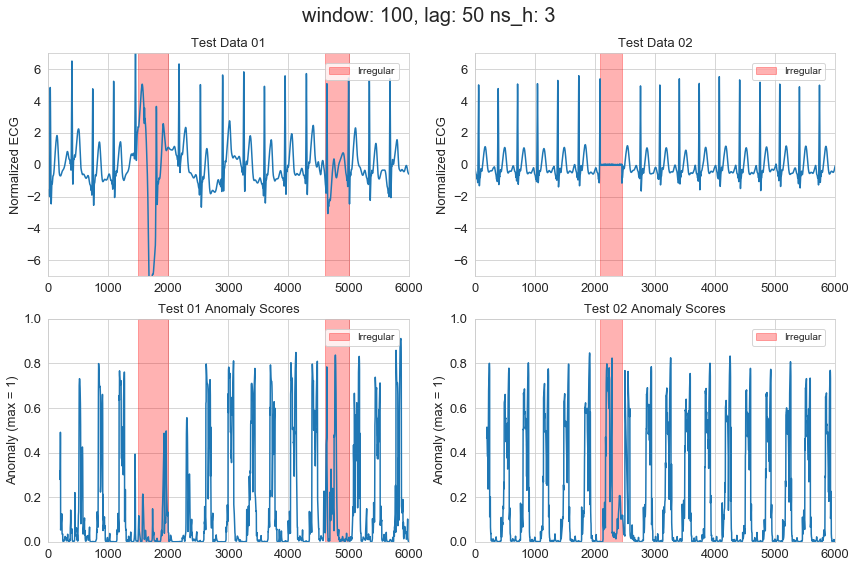

In [135]:
display_anomaly_score(test_01['ecg'].values, test_02['ecg'].values, ssa_anom_test_1, ssa_anom_test_2)

### Summary

- From the graphs, AR model is too sensitive for Test_01 and too dull for Test_02. 
- SSA (window:30, lag:50, ns_h:3) could detect Test_02 anomaly but could not well detect Test_01.
- It might not be good for data that have a lot of peaks. 
- KNN model (window:20) could detect Test01 and Test02 anomaly. And the peaks is clearer that the other models.
- Therefore, it is decided that KNN(window:20) is the best model to detect anomalous ECG this time. 
- The anomaly threshold for the app was decided at 0.18 from the best model graph.

### Save the model

In [160]:
train_vectors = embed(train['ecg'].values, 20)
test_vectors = embed(test_01['ecg'].values, 20)

In [161]:
kneibor = NearestNeighbors(n_neighbors=1)
kneibor.fit(train_vectors)

NearestNeighbors(n_neighbors=1)

In [162]:
d_test = kneibor.kneighbors(test_vectors)[0]

In [163]:
mx = np.array([np.max(d_test)])

In [164]:
np.savetxt('../data/knn_distance_max.csv', mx)

In [165]:
with open('../model/knn_model.pickle', 'wb') as f:
    pickle.dump(kneibor, f)

In [63]:
with open('../model/scaler.pickle', 'wb') as f:
    pickle.dump(sc, f)